In [1]:
%%capture
!pip install segmentation-models-pytorch==0.2.1 mlflow

In [2]:
# General Libraries
import os
import sys
import csv
import cv2
import yaml
import h5py
import errno
import shutil
import random
import mlflow
import pickle
import imageio
import inspect
import zipfile
import warnings
import argparse
import functools
import matplotlib
import collections
from collections.abc import Mapping 
import numpy as np
import pandas as pd
matplotlib.use('Agg')
from PIL import Image
from typing import Dict
import albumentations as albu
from enum import auto, Enum
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Sklearn metrics Libraries
from sklearn.metrics import accuracy_score, jaccard_score

# Pytorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.distributions import Normal, Independent, kl
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader,TensorDataset

# Segmentation Models on Pytorch Libraries
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from segmentation_models_pytorch.encoders import get_preprocessing_fn

## Probalistic Unet in Pytorch library functions

In [3]:
class LIDC_IDRI(Dataset):
    images = []
    labels = []
    series_uid = []

    def __init__(self, dataset_location, transform=None):
        self.transform = transform
        max_bytes = 2**31 - 1
        data = {}
        for file in os.listdir(dataset_location):
            filename = os.fsdecode(file)
            if '.pickle' in filename:
                print("Loading file", filename)
                file_path = dataset_location + filename
                bytes_in = bytearray(0)
                input_size = os.path.getsize(file_path)
                with open(file_path, 'rb') as f_in:
                    for _ in range(0, input_size, max_bytes):
                        bytes_in += f_in.read(max_bytes)
                new_data = pickle.loads(bytes_in)
                data.update(new_data)
        
        for key, value in data.items():
            self.images.append(value['image'].astype(float))
            self.labels.append(value['masks'])
            self.series_uid.append(value['series_uid'])

        assert (len(self.images) == len(self.labels) == len(self.series_uid))

        for img in self.images:
            assert np.max(img) <= 1 and np.min(img) >= 0
        for label in self.labels:
            assert np.max(label) <= 1 and np.min(label) >= 0

        del new_data
        del data

    def __getitem__(self, index):
        image = np.expand_dims(self.images[index], axis=0)

        #Randomly select one of the four labels for this image
        label = self.labels[index][random.randint(0,3)].astype(float)
        if self.transform is not None:
            image = self.transform(image)

        series_uid = self.series_uid[index]

        # Convert image and label to torch tensors
        image = torch.from_numpy(image)
        label = torch.from_numpy(label)

        #Convert uint8 to float tensors
        image = image.type(torch.FloatTensor)
        label = label.type(torch.FloatTensor)

        return image, label, series_uid

    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.images)

In [4]:

class Encoder(nn.Module):
    """
    A convolutional neural network, consisting of len(num_filters) times a block of no_convs_per_block convolutional layers,
    after each block a pooling operation is performed. And after each convolutional layer a non-linear (ReLU) activation function is applied.
    """
    def __init__(self, input_channels, num_filters, no_convs_per_block, initializers, padding=True, posterior=False):
        super(Encoder, self).__init__()
        self.contracting_path = nn.ModuleList()
        self.input_channels = input_channels
        self.num_filters = num_filters

        if posterior:
            #To accomodate for the mask that is concatenated at the channel axis, we increase the input_channels.
            self.input_channels += 1

        layers = []
        for i in range(len(self.num_filters)):
            """
            Determine input_dim and output_dim of conv layers in this block. The first layer is input x output,
            All the subsequent layers are output x output.
            """
            input_dim = self.input_channels if i == 0 else output_dim
            output_dim = num_filters[i]
            
            if i != 0:
                layers.append(nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True))
            
            layers.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=int(padding)))
            layers.append(nn.ReLU(inplace=True))

            for _ in range(no_convs_per_block-1):
                layers.append(nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=int(padding)))
                layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*layers)

        self.layers.apply(init_weights)

    def forward(self, input):
        output = self.layers(input)
        return output

class AxisAlignedConvGaussian(nn.Module):
    """
    A convolutional net that parametrizes a Gaussian distribution with axis aligned covariance matrix.
    """
    def __init__(self, input_channels, num_filters, no_convs_per_block, latent_dim, initializers, posterior=False):
        super(AxisAlignedConvGaussian, self).__init__()
        self.input_channels = input_channels
        self.channel_axis = 1
        self.num_filters = num_filters
        self.no_convs_per_block = no_convs_per_block
        self.latent_dim = latent_dim
        self.posterior = posterior
        if self.posterior:
            self.name = 'Posterior'
        else:
            self.name = 'Prior'
        self.encoder = Encoder(self.input_channels, self.num_filters, self.no_convs_per_block, initializers, posterior=self.posterior)
        self.conv_layer = nn.Conv2d(num_filters[-1], 2 * self.latent_dim, (1,1), stride=1)
        self.show_img = 0
        self.show_seg = 0
        self.show_concat = 0
        self.show_enc = 0
        self.sum_input = 0

        nn.init.kaiming_normal_(self.conv_layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.conv_layer.bias)

    def forward(self, input, segm=None):

        #If segmentation is not none, concatenate the mask to the channel axis of the input
        if segm is not None:
            self.show_img = input
            self.show_seg = segm
            input = torch.cat((input, segm), dim=1)
            self.show_concat = input
            self.sum_input = torch.sum(input)

        encoding = self.encoder(input)
        self.show_enc = encoding

        #We only want the mean of the resulting hxw image
        encoding = torch.mean(encoding, dim=2, keepdim=True)
        encoding = torch.mean(encoding, dim=3, keepdim=True)

        #Convert encoding to 2 x latent dim and split up for mu and log_sigma
        mu_log_sigma = self.conv_layer(encoding)

        #We squeeze the second dimension twice, since otherwise it won't work when batch size is equal to 1
        mu_log_sigma = torch.squeeze(mu_log_sigma, dim=2)
        mu_log_sigma = torch.squeeze(mu_log_sigma, dim=2)

        mu = mu_log_sigma[:,:self.latent_dim]
        log_sigma = mu_log_sigma[:,self.latent_dim:]

        #This is a multivariate normal with diagonal covariance matrix sigma
        #https://github.com/pytorch/pytorch/pull/11178
        dist = Independent(Normal(loc=mu, scale=torch.exp(log_sigma)),1)
        return dist

class Fcomb(nn.Module):
    """
    A function composed of no_convs_fcomb times a 1x1 convolution that combines the sample taken from the latent space,
    and output of the UNet (the feature map) by concatenating them along their channel axis.
    """
    def __init__(self, num_filters, latent_dim, num_output_channels, num_classes, no_convs_fcomb, initializers, use_tile=True):
        super(Fcomb, self).__init__()
        self.num_channels = num_output_channels #output channels
        self.num_classes = num_classes
        self.channel_axis = 1
        self.spatial_axes = [2,3]
        self.num_filters = num_filters
        self.latent_dim = latent_dim
        self.use_tile = use_tile
        self.no_convs_fcomb = no_convs_fcomb 
        self.name = 'Fcomb'

        if self.use_tile:
            layers = []

            #Decoder of N x a 1x1 convolution followed by a ReLU activation function except for the last layer
            layers.append(nn.Conv2d(self.num_filters[0]+self.latent_dim, self.num_filters[0], kernel_size=1))
            layers.append(nn.ReLU(inplace=True))

            for _ in range(no_convs_fcomb-2):
                layers.append(nn.Conv2d(self.num_filters[0], self.num_filters[0], kernel_size=1))
                layers.append(nn.ReLU(inplace=True))

            self.layers = nn.Sequential(*layers)

            self.last_layer = nn.Conv2d(self.num_filters[0], self.num_classes, kernel_size=1)

            if initializers['w'] == 'orthogonal':
                self.layers.apply(init_weights_orthogonal_normal)
                self.last_layer.apply(init_weights_orthogonal_normal)
            else:
                self.layers.apply(init_weights)
                self.last_layer.apply(init_weights)

    def tile(self, a, dim, n_tile):
        """
        This function is taken form PyTorch forum and mimics the behavior of tf.tile.
        Source: https://discuss.pytorch.org/t/how-to-tile-a-tensor/13853/3
        """
        init_dim = a.size(dim)
        repeat_idx = [1] * a.dim()
        repeat_idx[dim] = n_tile
        a = a.repeat(*(repeat_idx))
        order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).to(device)
        return torch.index_select(a, dim, order_index)

    def forward(self, feature_map, z):
        """
        Z is batch_sizexlatent_dim and feature_map is batch_sizexno_channelsxHxW.
        So broadcast Z to batch_sizexlatent_dimxHxW. Behavior is exactly the same as tf.tile (verified)
        """
        if self.use_tile:
            z = torch.unsqueeze(z,2)
            z = self.tile(z, 2, feature_map.shape[self.spatial_axes[0]])
            z = torch.unsqueeze(z,3)
            z = self.tile(z, 3, feature_map.shape[self.spatial_axes[1]])

            #Concatenate the feature map (output of the UNet) and the sample taken from the latent space
            feature_map = torch.cat((feature_map, z), dim=self.channel_axis)
            output = self.layers(feature_map)
            return self.last_layer(output)


class ProbabilisticUnet(nn.Module):
    """
    A probabilistic UNet (https://arxiv.org/abs/1806.05034) implementation.
    input_channels: the number of channels in the image (1 for greyscale and 3 for RGB)
    num_classes: the number of classes to predict
    num_filters: is a list consisint of the amount of filters layer
    latent_dim: dimension of the latent space
    no_cons_per_block: no convs per block in the (convolutional) encoder of prior and posterior
    """

    def __init__(self, input_channels=1, num_classes=1, num_filters=[32,64,128,192], latent_dim=6, no_convs_fcomb=4, beta=10.0):
        super(ProbabilisticUnet, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.latent_dim = latent_dim
        self.no_convs_per_block = 3
        self.no_convs_fcomb = no_convs_fcomb
        self.initializers = {'w':'he_normal', 'b':'normal'}
        self.beta = beta
        self.z_prior_sample = 0

        self.unet = Unet(self.input_channels, self.num_classes, self.num_filters, self.initializers, apply_last_layer=False, padding=True).to(device)
        self.prior = AxisAlignedConvGaussian(self.input_channels, self.num_filters, self.no_convs_per_block, self.latent_dim,  self.initializers,).to(device)
        self.posterior = AxisAlignedConvGaussian(self.input_channels, self.num_filters, self.no_convs_per_block, self.latent_dim, self.initializers, posterior=True).to(device)
        self.fcomb = Fcomb(self.num_filters, self.latent_dim, self.input_channels, self.num_classes, self.no_convs_fcomb, {'w':'orthogonal', 'b':'normal'}, use_tile=True).to(device)

    def forward(self, patch, segm, training=True):
        """
        Construct prior latent space for patch and run patch through UNet,
        in case training is True also construct posterior latent space
        """
        if training:
            self.posterior_latent_space = self.posterior.forward(patch, segm)
        self.prior_latent_space = self.prior.forward(patch)
        self.unet_features = self.unet.forward(patch,False)

    def sample(self, testing=False):
        """
        Sample a segmentation by reconstructing from a prior sample
        and combining this with UNet features
        """
        if testing == False:
            z_prior = self.prior_latent_space.rsample()
            self.z_prior_sample = z_prior
        else:
            #You can choose whether you mean a sample or the mean here. For the GED it is important to take a sample.
            #z_prior = self.prior_latent_space.base_dist.loc 
            z_prior = self.prior_latent_space.sample()
            self.z_prior_sample = z_prior
        return self.fcomb.forward(self.unet_features,z_prior)


    def reconstruct(self, use_posterior_mean=False, calculate_posterior=False, z_posterior=None):
        """
        Reconstruct a segmentation from a posterior sample (decoding a posterior sample) and UNet feature map
        use_posterior_mean: use posterior_mean instead of sampling z_q
        calculate_posterior: use a provided sample or sample from posterior latent space
        """
        if use_posterior_mean:
            z_posterior = self.posterior_latent_space.loc
        else:
            if calculate_posterior:
                z_posterior = self.posterior_latent_space.rsample()
        return self.fcomb.forward(self.unet_features, z_posterior)

    def kl_divergence(self, analytic=True, calculate_posterior=False, z_posterior=None):
        """
        Calculate the KL divergence between the posterior and prior KL(Q||P)
        analytic: calculate KL analytically or via sampling from the posterior
        calculate_posterior: if we use samapling to approximate KL we can sample here or supply a sample
        """
        if analytic:
            #Neeed to add this to torch source code, see: https://github.com/pytorch/pytorch/issues/13545
            kl_div = kl.kl_divergence(self.posterior_latent_space, self.prior_latent_space)
        else:
            if calculate_posterior:
                z_posterior = self.posterior_latent_space.rsample()
            log_posterior_prob = self.posterior_latent_space.log_prob(z_posterior)
            log_prior_prob = self.prior_latent_space.log_prob(z_posterior)
            kl_div = log_posterior_prob - log_prior_prob
        return kl_div

    def elbo(self, segm, analytic_kl=True, reconstruct_posterior_mean=False):
        """
        Calculate the evidence lower bound of the log-likelihood of P(Y|X)
        """

        criterion = nn.BCEWithLogitsLoss(size_average = False, reduce=False, reduction=None)
        z_posterior = self.posterior_latent_space.rsample()
        
        self.kl = torch.mean(self.kl_divergence(analytic=analytic_kl, calculate_posterior=False, z_posterior=z_posterior))

        #Here we use the posterior sample sampled above
        self.reconstruction = self.reconstruct(use_posterior_mean=reconstruct_posterior_mean, calculate_posterior=False, z_posterior=z_posterior)
        
        reconstruction_loss = criterion(input=self.reconstruction, target=segm)
        self.reconstruction_loss = torch.sum(reconstruction_loss)
        self.mean_reconstruction_loss = torch.mean(reconstruction_loss)

        return -(self.reconstruction_loss + self.beta * self.kl)

In [5]:
class Unet(nn.Module):
    """
    A UNet (https://arxiv.org/abs/1505.04597) implementation.
    input_channels: the number of channels in the image (1 for greyscale and 3 for RGB)
    num_classes: the number of classes to predict
    num_filters: list with the amount of filters per layer
    apply_last_layer: boolean to apply last layer or not (not used in Probabilistic UNet)
    padidng: Boolean, if true we pad the images with 1 so that we keep the same dimensions
    """

    def __init__(self, input_channels, num_classes, num_filters, initializers, apply_last_layer=True, padding=True):
        super(Unet, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.padding = padding
        self.activation_maps = []
        self.apply_last_layer = apply_last_layer
        self.contracting_path = nn.ModuleList()

        for i in range(len(self.num_filters)):
            input = self.input_channels if i == 0 else output
            output = self.num_filters[i]

            if i == 0:
                pool = False
            else:
                pool = True

            self.contracting_path.append(DownConvBlock(input, output, initializers, padding, pool=pool))

        self.upsampling_path = nn.ModuleList()

        n = len(self.num_filters) - 2
        for i in range(n, -1, -1):
            input = output + self.num_filters[i]
            output = self.num_filters[i]
            self.upsampling_path.append(UpConvBlock(input, output, initializers, padding))

        if self.apply_last_layer:
            self.last_layer = nn.Conv2d(output, num_classes, kernel_size=1)
            #nn.init.kaiming_normal_(self.last_layer.weight, mode='fan_in',nonlinearity='relu')
            #nn.init.normal_(self.last_layer.bias)


    def forward(self, x, val):
        blocks = []
        for i, down in enumerate(self.contracting_path):
            x = down(x)
            if i != len(self.contracting_path)-1:
                blocks.append(x)

        for i, up in enumerate(self.upsampling_path):
            x = up(x, blocks[-i-1])

        del blocks

        #Used for saving the activations and plotting
        if val:
            self.activation_maps.append(x)
        
        if self.apply_last_layer:
            x =  self.last_layer(x)

        return x

In [6]:
class DownConvBlock(nn.Module):
    """
    A block of three convolutional layers where each layer is followed by a non-linear activation function
    Between each block we add a pooling operation.
    """
    def __init__(self, input_dim, output_dim, initializers, padding, pool=True):
        super(DownConvBlock, self).__init__()
        layers = []

        if pool:
            layers.append(nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True))

        layers.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=1, padding=int(padding)))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=int(padding)))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=int(padding)))
        layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*layers)

        self.layers.apply(init_weights)

    def forward(self, patch):
        return self.layers(patch)


class UpConvBlock(nn.Module):
    """
    A block consists of an upsampling layer followed by a convolutional layer to reduce the amount of channels and then a DownConvBlock
    If bilinear is set to false, we do a transposed convolution instead of upsampling
    """
    def __init__(self, input_dim, output_dim, initializers, padding, bilinear=True):
        super(UpConvBlock, self).__init__()
        self.bilinear = bilinear

        if not self.bilinear:
            self.upconv_layer = nn.ConvTranspose2d(input_dim, output_dim, kernel_size=2, stride=2)
            self.upconv_layer.apply(init_weights)

        self.conv_block = DownConvBlock(input_dim, output_dim, initializers, padding, pool=False)

    def forward(self, x, bridge):
        if self.bilinear:
            up = nn.functional.interpolate(x, mode='bilinear', scale_factor=2, align_corners=True)
        else:
            up = self.upconv_layer(x)
        
        assert up.shape[3] == bridge.shape[3]
        out = torch.cat([up, bridge], 1)
        out =  self.conv_block(out)

        return out

In [7]:
def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #nn.init.normal_(m.weight, std=0.001)
        #nn.init.normal_(m.bias, std=0.001)
        truncated_normal_(m.bias, mean=0, std=0.001)

def init_weights_orthogonal_normal(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.orthogonal_(m.weight)
        truncated_normal_(m.bias, mean=0, std=0.001)
        #nn.init.normal_(m.bias, std=0.001)

def l2_regularisation(m):
    l2_reg = None

    for W in m.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return l2_reg

def save_mask_prediction_example(mask, pred, iter):
    plt.imshow(pred[0,:,:],cmap='Greys')
    plt.savefig('images/'+str(iter)+"_prediction.png")
    plt.imshow(mask[0,:,:],cmap='Greys')
    plt.savefig('images/'+str(iter)+"_mask.png")

## Crowds for automated histopathological image segmentation functions

In [8]:
def double_conv(in_channels, out_channels, step, norm):
    # ===========================================
    # in_channels: dimension of input
    # out_channels: dimension of output
    # step: stride
    # ===========================================
    if norm == 'in':
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, stride=step, padding=1, groups=1, bias=False),
            torch.nn.InstanceNorm2d(out_channels, affine=True),
            torch.nn.PReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, groups=1, bias=False),
            torch.nn.InstanceNorm2d(out_channels, affine=True),
            torch.nn.PReLU()
        )
    elif norm == 'bn':
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, stride=step, padding=1, groups=1, bias=False),
            torch.nn.BatchNorm2d(out_channels, affine=True),
            torch.nn.PReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, groups=1, bias=False),
            torch.nn.BatchNorm2d(out_channels, affine=True),
            torch.nn.PReLU()
        )
    elif norm == 'ln':
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, stride=step, padding=1, groups=1, bias=False),
            torch.nn.GroupNorm(out_channels, out_channels, affine=True),
            torch.nn.PReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, groups=1, bias=False),
            torch.nn.GroupNorm(out_channels, out_channels, affine=True),
            torch.nn.PReLU()
        )
    elif norm == 'gn':
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, stride=step, padding=1, groups=1, bias=False),
            torch.nn.GroupNorm(out_channels // 8, out_channels, affine=True),
            torch.nn.PReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, groups=1, bias=False),
            torch.nn.GroupNorm(out_channels // 8, out_channels, affine=True),
            torch.nn.PReLU()
        )



class global_CM(torch.nn.Module):
    """ This defines the annotator network (CR Global)
    """

    def __init__(self, class_no, input_height, input_width, noisy_labels_no):
        super(global_CM, self).__init__()
        self.class_no = class_no
        self.noisy_labels_no = noisy_labels_no
        self.input_height = input_height
        self.input_width = input_width
        self.noisy_labels_no = noisy_labels_no
        self.dense_output = torch.nn.Linear(noisy_labels_no, class_no ** 2)
        self.act = torch.nn.Softplus()
        # self.relu = torch.nn.ReLU()

    def forward(self, A_id, x=None):
        output = self.act(self.dense_output(A_id))
        all_weights = output.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 1, 512, 512)
        y = all_weights.view(-1, self.class_no**2, self.input_height, self.input_width)



        return y


class conv_layers_image(torch.nn.Module):
    def __init__(self, in_channels):
        super(conv_layers_image, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_bn = torch.nn.BatchNorm2d(8)
        self.conv_bn2 = torch.nn.BatchNorm2d(4)
        self.fc_bn = torch.nn.BatchNorm1d(128)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(in_features=4096, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=64)

    def forward(self, x):
        x = self.pool(self.relu(self.conv_bn(self.conv(x))))
        x = self.pool(self.relu(self.conv_bn2(self.conv2(x))))
        x = self.pool(self.relu(self.conv_bn2(self.conv3(x))))
        x = self.pool(self.relu(self.conv_bn2(self.conv3(x))))
        x = self.flatten(x)

        x = self.relu(self.fc_bn(self.fc1(x)))
        y = self.fc2(x)

        return y


class image_CM(torch.nn.Module):
    """ This defines the annotator network (CR Image)
    """

    def __init__(self, class_no, input_height, input_width, noisy_labels_no):
        super(image_CM, self).__init__()
        self.class_no = class_no
        self.noisy_labels_no = noisy_labels_no
        self.input_height = input_height
        self.input_width = input_width
        self.noisy_labels_no = noisy_labels_no
        self.conv_layers = conv_layers_image(16)
        self.dense_annotator = torch.nn.Linear(noisy_labels_no, 64)
        self.dense_output = torch.nn.Linear(128, class_no ** 2)
        self.norm = torch.nn.BatchNorm1d(class_no ** 2)
        self.act = torch.nn.Softplus()

    def forward(self, A_id, x):
        A_feat = self.dense_annotator(A_id)  # B, F_A
        x = self.conv_layers(x)
        output = self.dense_output(torch.hstack((A_feat, x)))
        output = self.norm(output)
        output = self.act(output.view(-1, self.class_no, self.class_no))
        all_weights = output.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 1, self.input_height, self.input_width)
        y = all_weights.view(-1, self.class_no**2, self.input_height, self.input_width)

        return y



class cm_layers(torch.nn.Module):
    """ This defines the annotator network (CR Pixel)
    """

    def __init__(self, in_channels, norm, class_no, noisy_labels_no):
        super(cm_layers, self).__init__()
        self.conv_1 = double_conv(in_channels=in_channels, out_channels=in_channels, norm=norm, step=1)
        self.conv_2 = double_conv(in_channels=in_channels, out_channels=in_channels, norm=norm, step=1)
        # self.conv_last = torch.nn.Conv2d(in_channels, class_no ** 2, 1, bias=True)
        self.class_no = class_no
        self.dense = torch.nn.Linear(80, 25)
        self.dense2 = torch.nn.Linear(25, 25)
        self.dense_annotator = torch.nn.Linear(noisy_labels_no, 64)
        # self.dense_classes = torch.nn.Linear(noisy_labels_no, 50)
        self.norm = torch.nn.BatchNorm2d(80, affine=True)
        self.relu = torch.nn.Softplus()
        self.act = torch.nn.Softmax(dim=3)

    def forward(self, A_id, x):
        print('################################################4\n')
        y = self.conv_2(self.conv_1(x))
        print(f'y shape: {y.shape}\n')
        A_id = self.relu(self.dense_annotator(A_id))  # B, F_A
        print(f'A_id shape: {A_id.shape}\n')
        A_id = A_id.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 512, 512)
        print(f'A_id shape: {A_id.shape}\n')
        
        y = torch.cat((A_id, y), dim=1)
        print(f'y shape: {y.shape}\n')
        y = self.norm(y)
        print(f'y shape: {y.shape}\n')
        y = y.permute(0, 2, 3, 1)
        print(f'y shape: {y.shape}\n')
        y = self.relu((self.dense(y)))
        print(f'y shape: {y.shape}\n')
        y = self.dense2(y)
        print(f'y shape: {y.shape}\n')
        
        # Verificar el tamaño actual del tensor
        print(f"Current tensor size before view: {y.size()}")

        # Calcular la nueva forma
        print(self.class_no)
        expected_shape = (-1, 512, 512, 5 * self.class_no)  # Adjust shape to match actual tensor size
        expected_size = torch.prod(torch.tensor(expected_shape[1:])).item()  # Calculate expected size

        if y.numel() == expected_size:
            y = self.relu(y.view(expected_shape))
        else:
            raise RuntimeError(f"Expected size {expected_size} but got {y.numel()}")

        y = y.view(-1, 512, 512, self.class_no ** 2).permute(0, 3, 1, 2)

        return y
    
class Crowd_segmentationModel(torch.nn.Module):
    """ This defines the architecture of the chosen CR method
    """
    def __init__(self, noisy_labels):
        super().__init__()
        self.seg_model = create_segmentation_backbone()
        self.activation = torch.nn.Softmax(dim=1)
        self.noisy_labels_no = len(noisy_labels)
        print("Number of annotators (model): ", self.noisy_labels_no)
        self.class_no = config['data']['class_no']
        self.crowd_type = config['model']['crowd_type']
        if self.crowd_type == 'global':
            print("Global crowdsourcing")
            self.crowd_layers = global_CM(self.class_no, 512, 512, self.noisy_labels_no)
        elif self.crowd_type == 'image': 
            print("Image dependent crowdsourcing")
            self.crowd_layers = image_CM(self.class_no, 512, 512, self.noisy_labels_no)
        elif self.crowd_type == 'pixel':
            print("Pixel dependent crowdsourcing")
            self.crowd_layers = cm_layers(in_channels=16, norm='in',
                                                  class_no=config['data']['class_no'], noisy_labels_no=self.noisy_labels_no)  
        self.activation = torch.nn.Softmax(dim=1)

    def forward(self, x, A_id=None):
        cm = None
        #print('################################################3\n')
        #print(f'1nd x shape: {x.shape} \n')
        x = self.seg_model.encoder(x)
        #print(f'2nd x len: {len(x)}\nshape 0 {x[0].shape}\nshape 1 {x[1].shape}\nshape 2 {x[2].shape}\nshape 3 {x[3].shape}\nshape 4 {x[4].shape}\nshape 5 {x[5].shape}')
        x = self.seg_model.decoder(*x)
        if A_id is not None:
            #print(f'A_id shape: {A_id.shape}, 3nd x shape: {x.shape} \n')
            cm = self.crowd_layers(A_id, x)
        x = self.seg_model.segmentation_head(x)
        y = self.activation(x)
        return y, cm

In [9]:
config = {}

def config_update(orig_dict, new_dict):
    for key, val in new_dict.items():
        if isinstance(val, Mapping):
            tmp = config_update(orig_dict.get(key, { }), val)
            orig_dict[key] = tmp
        elif isinstance(val, list):
            orig_dict[key] = val
        else:
            orig_dict[key] = new_dict[key]
    return orig_dict

def init_global_config(args):
    global config

    # load default config
    with open(args.default_config) as file:
        config = yaml.full_load(file)

    # load dataset config, overwrite parameters if double
    with open(config["data"]["dataset_config"]) as file:
        config_data_dependent = yaml.full_load(file)
    config = config_update(config, config_data_dependent)

    # load experiment config, overwrite parameters if double
    if args.experiment_folder != 'None':
        experiment_config = os.path.join(args.experiment_folder, 'exp_config.yaml')
        if os.path.exists(experiment_config):
            with open(experiment_config) as file:
                exp_config = yaml.full_load(file)
            config = config_update(config, exp_config)
        config['logging']['experiment_folder'] = args.experiment_folder
        if config['data']['crowd']:
            exp_fold = args.experiment_folder.split("/")[-3:]
        else:
            exp_fold = args.experiment_folder.split("/")[-2:]
        exp_fold = "_".join(exp_fold)
        config['logging']['run_name'] = exp_fold
    else:
        out_dir = './output/'
        os.makedirs(out_dir, exist_ok=True)
        warnings.warn("No experiment folder was given. Use ./output folder to store experiment results.")
        config['logging']['experiment_folder'] = out_dir
        config['logging']['run_name'] = 'default'

In [10]:
def start_logging():
    mlflow.set_tracking_uri(config["logging"]["mlruns_folder"])

    data_config_log = config['data'].copy()
    data_config_log.pop('visualize_images') # drop this because it is often to long to be logged

    # experiment = mlflow.set_experiment(experiment_name=config["data"]["dataset_name"])
    mlflow.set_experiment(experiment_name=config["data"]["dataset_name"])
    # with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='test') as run:
    # mlflow.start_run(experiment_id=experiment.experiment_id, run_name='test')
    mlflow.start_run(run_name=config['logging']['run_name'])
    print('tracking uri:', mlflow.get_tracking_uri())
    print('artifact uri:', mlflow.get_artifact_uri())
    mlflow.log_params(config['model'])
    mlflow.log_params(data_config_log)
    mlflow.log_artifact('/kaggle/working/OxfordPet/config.yaml')


def log_results(results, mode, step=None):

    formatted_results = {}

    for key in results.keys():
        new_key = mode + '_' + key
        formatted_results[new_key] = results[key]

    mlflow.log_metrics(formatted_results, step=step)

## Noisy Label Loss for Segmentation in Deep Learning

Given a $k$-class multiple annotators segmentation problem with a dataset like the following:

$$\mathbf X \in \mathbb{R}^{W \times H}, \{ \mathbf Y_r \in \{0,1\}^{W \times H \times K} \}_{r=1}^R; \;\; \mathbf {\hat Y} \in [0,1]^{W\times H \times K} = f(\mathbf X)$$

The segmentation mask function will map input to output as follows:

$$f: \mathbb R ^{W \times H} \to [0,1]^{W \times H \times K}$$

$\mathbf Y$ will satisfy the following condition for being a softmax-like representation:

$$\mathbf Y_r[w,h,:] \mathbf{1}^\top _ k = 1; \;\; w \in W, h \in H$$

Let's assume the existence of a confusion matrix $\mathbf{C}_m$ for each sample, where $\mathbf{C}_m \in \mathbb{R}^{K \times K}$.

The noisy label loss for a single sample can be defined as follows:

$$\mathcal{L}_{noisy}(\mathbf{\hat{Y}}, \mathbf{Y}) = \mathcal{L}_{ce}(\mathbf{\hat{Y}}_{noisy}, \mathbf{Y}) + \alpha \cdot \mathcal{R}(\mathbf{C}_m)$$

Where $\mathbf{\hat{Y}}_{noisy}$ is the predicted noisy label, which is obtained by applying the confusion matrix to the predicted label:

$$\mathbf{\hat{Y}}_{noisy} = \mathbf{C}_m \cdot \mathbf{\hat{Y}}$$

The cross-entropy loss $\mathcal{L}_{ce}$ is defined as:

$$\mathcal{L}_{ce}(\mathbf{\hat{Y}}_{noisy}, \mathbf{Y}) = -\frac{1}{W \times H} \sum_{w=1}^W \sum_{h=1}^H \sum_{k=1}^K \mathbf{Y}[w,h,k] \cdot \log(\mathbf{\hat{Y}}_{noisy}[w,h,k])$$

The regularization term $\mathcal{R}(\mathbf{C}_m)$ is defined as:

$$\mathcal{R}(\mathbf{C}_m) = \frac{\text{trace}(\mathbf{C}_m^\top)}{W \times H \times K}$$

Where $\alpha$ is a hyperparameter that controls the strength of the regularization.

The total loss for a batch of $N$ samples is defined as:

$$\mathcal{L}_{total} = \frac{1}{N} \sum_{n=1}^N \mathcal{L}_{noisy}(\mathbf{\hat{Y}}_n, \mathbf{Y}_n)$$

Where $\mathbf{\hat{Y}}_n$ and $\mathbf{Y}_n$ are the predicted and true labels for the $n$-th sample in the batch, respectively.

In [11]:
torch.backends.cudnn.deterministic = True
eps=1e-7

def noisy_label_loss(pred, cms, labels, ignore_index, min_trace = False, alpha=0.1, loss_mode=None):
    """ Loss for the crowdsourcing methods
    """
    b, c, h, w = pred.size()

    #
    pred_norm = pred.view(b, c, h*w).permute(0, 2, 1).contiguous().view(b*h*w, c, 1)
    cm = cms.view(b, c ** 2, h * w).permute(0, 2, 1).contiguous().view(b * h * w, c * c).view(b * h * w, c, c)
    cm = cm / cm.sum(1, keepdim=True)

    pred_noisy = torch.bmm(cm, pred_norm).view(b*h*w, c)
    pred_noisy = pred_noisy.view(b, h*w, c).permute(0, 2, 1).contiguous().view(b, c, h, w)

    if loss_mode == 'ce':
        loss_ce = nn.NLLLoss(reduction='mean', ignore_index=ignore_index)(torch.log(pred_noisy+eps), labels.view(b, h, w).long())
    elif loss_mode == 'dice':
        loss_ce = DiceLoss(ignore_index=ignore_index, from_logits=False, mode='multiclass')(pred_noisy, labels.view(b, h, w).long())
    elif loss_mode == 'focal':
        loss_ce = FocalLoss(reduction='mean', ignore_index=ignore_index, mode='multiclass')(pred_noisy, labels.view(b, h, w).long())

    # regularization
    regularisation = torch.trace(torch.transpose(torch.sum(cm, dim=0), 0, 1)).sum() / (b * h * w)
    regularisation = alpha * regularisation

    if min_trace:
        loss = loss_ce + regularisation
    else:
        loss = loss_ce - regularisation

    return loss, loss_ce, regularisation

In [12]:
import segmentation_models_pytorch as smp


def create_segmentation_backbone():
    class_no = config['data']['class_no']

    if config['model']['backbone'] == 'unet':
        seg_model = smp.Unet(
            encoder_name=config['model']['encoder']['backbone'],  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=config['model']['encoder']['weights'],
            # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=class_no,  # model output channels (number of classes in your dataset)           
        )
        
    elif config['model']['backbone'] == 'linknet':
        seg_model = smp.Linknet(
            encoder_name=config['model']['encoder']['backbone'],  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=config['model']['encoder']['weights'],
            # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=class_no  # model output channels (number of classes in your dataset)
        )
    else:
        raise Exception('Choose valid model backbone!')
    return seg_model


class SegmentationModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.seg_model = create_segmentation_backbone()
        self.activation = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.seg_model(x)
        y = self.activation(x)
        return y

In [13]:
def preprocess_input(
    x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs
):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


def get_preprocessing_params():
    formatted_settings = {}
    formatted_settings["input_range"] = (0,1)
    formatted_settings["input_space"] = "RGB"
    formatted_settings["mean"] = None
    formatted_settings["std"] = None
    return formatted_settings


def get_preprocessing_fn_without_normalization():
    params = get_preprocessing_params()
    return functools.partial(preprocess_input, **params)

In [14]:
def save_model(model):
    model_dir = 'models'
    dir = os.path.join(config['logging']['experiment_folder'], model_dir)
    os.makedirs(dir, exist_ok=True)
    out_path = os.path.join(dir, 'best_model.pth')
    torch.save(model, out_path)
    print('Best Model saved!')

def save_test_images(test_imgs:torch.Tensor, test_preds: np.array, test_labels: np.array, test_name: np.array, mode: str):
    visual_dir = 'qualitative_results/' + mode
    dir = os.path.join(config['logging']['experiment_folder'], visual_dir)
    os.makedirs(dir, exist_ok=True)

    h, w = np.shape(test_labels)

    test_preds = np.asarray(test_preds, dtype=np.uint8)
    test_labels = np.asarray(test_labels, dtype=np.uint8)

    # print("test name ", test_name)
    out_path = os.path.join(dir, 'img_' + test_name)
    save_image(test_imgs, out_path)

    test_pred_rgb = convert_classes_to_rgb(test_preds, h, w)
    out_path = os.path.join(dir, 'pred_' + test_name)
    imageio.imsave(out_path, test_pred_rgb)

    test_label_rgb = convert_classes_to_rgb(test_labels, h, w)
    out_path = os.path.join(dir, 'gt_' + test_name)
    imageio.imsave(out_path, test_label_rgb)
    mlflow.log_artifacts(dir, visual_dir)

# TODO: funcion que guarde bien el crowdsourcing
def save_crowd_images(test_imgs:torch.Tensor, gt_pred: np.array, test_preds: np.array, test_labels: np.array, test_name: np.array, annotator, cm):
    visual_dir = 'qualitative_results/' + "train_crowd"
    dir = os.path.join(config['logging']['experiment_folder'], visual_dir)
    os.makedirs(dir, exist_ok=True)

    h, w = np.shape(test_labels)

    test_preds = np.asarray(test_preds, dtype=np.uint8)
    test_labels = np.asarray(test_labels, dtype=np.uint8)

    # print("test name ", test_name)
    out_path = os.path.join(dir, 'img_' + test_name)
    save_image(test_imgs, out_path)

    test_pred_rgb = convert_classes_to_rgb(test_preds, h, w)
    out_path = os.path.join(dir, annotator + '_pred_' + test_name)
    imageio.imsave(out_path, test_pred_rgb)

    gt_pred_rgb = convert_classes_to_rgb(gt_pred, h, w)
    out_path = os.path.join(dir, 'gt_pred_' + test_name)
    imageio.imsave(out_path, gt_pred_rgb)

    test_label_rgb = convert_classes_to_rgb(test_labels, h, w)
    out_path = os.path.join(dir, annotator + '_gt_' + test_name)
    imageio.imsave(out_path, test_label_rgb)

    cm = cm.detach().cpu().numpy()
    plt.matshow(cm)
    out_path = os.path.join(dir, annotator + '_matrix_' + test_name)
    plt.savefig(out_path)

    mlflow.log_artifacts(dir, visual_dir)


def save_image_color_legend():
    visual_dir = 'qualitative_results/'
    dir = os.path.join(config['logging']['experiment_folder'], visual_dir)
    os.makedirs(dir, exist_ok=True)
    class_no = config['data']['class_no']
    class_names = config['data']['class_names']

    fig = plt.figure()

    size = 100

    for class_id in range(class_no):
        # out_img[size*class_id:size*(class_id+1),:,:] = convert_classes_to_rgb(np.ones(size,size,3)*class_id, size,size)
        out_img = convert_classes_to_rgb(np.ones(shape=[size,size])*class_id, size,size)
        ax = fig.add_subplot(1, class_no, class_id+1)
        ax.imshow(out_img)
        ax.set_title(class_names[class_id])
        ax.axis('off')
    plt.savefig(dir + 'legend.png')
    mlflow.log_artifact(dir + 'legend.png', 'qualitative_results')


def convert_classes_to_rgb(seg_classes, h, w):

    seg_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    class_no = config['data']['class_no']

    colors = [[0,179,255], [153,0,0], [255,102,204], [0,153,51], [153,0,204]]

    for class_id in range(class_no):
        seg_rgb[:, :, 0][seg_classes == class_id] = colors[class_id][0]
        seg_rgb[:, :, 1][seg_classes == class_id] = colors[class_id][1]
        seg_rgb[:, :, 2][seg_classes == class_id] = colors[class_id][2]

    return seg_rgb


def save_results(results):
    results_dir = 'quantitative_results'
    dir = os.path.join(config['logging']['experiment_folder'], results_dir)
    os.makedirs(dir, exist_ok=True)
    out_path = os.path.join(dir, 'results.csv')

    with open(out_path, 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in results.items():
            writer.writerow([key, value])

In [15]:
def dice_coef_binary(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def dice_coef_multilabel(y_true, y_pred):
    class_no = config['data']['class_no']
    dice_per_class = []
    for index in range(class_no):
        dice_per_class.append(dice_coef_binary(y_true == index, y_pred == index))

    return np.array(dice_per_class)

def segmentation_scores(label_trues, label_preds, metric_names):
    '''
    :param label_trues:
    :param label_preds:
    :param n_class:
    :return:
    '''
    results = {}
    class_no = config['data']['class_no']
    class_names = config['data']['class_names']
    ignore_last_class = config['data']['ignore_last_class']

    assert len(label_trues) == len(label_preds)

    label_preds = np.array(label_preds, dtype='int8')
    label_trues = np.array(label_trues, dtype='int8')

    if ignore_last_class:
        label_preds = label_preds[label_trues!=class_no]
        label_trues = label_trues[label_trues!=class_no]

    dice_per_class = dice_coef_multilabel(label_trues, label_preds)

    results['macro_dice'] = dice_per_class.mean()

    intersection = (label_preds == label_trues).sum(axis=None)
    sum_ = 2 * np.prod(label_preds.shape)
    results['micro_dice'] = ((2 * intersection + 1e-6) / (sum_ + 1e-6))

    for class_id in range(class_no):
        results['dice_class_' + str(class_id) + '_' + class_names[class_id]] = dice_per_class[class_id]

    results['accuracy'] = accuracy_score(label_trues, label_preds)
    results['miou'] = jaccard_score(label_trues, label_preds, average="macro") # same as IoU!

    for metric in metric_names:
        assert metric in results.keys()

    return results

In [16]:
def get_training_augmentation():
    aug_config = config['data']['augmentation']
    if aug_config['use_augmentation']:
        train_transform = [
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5),
            albu.RandomRotate90(p=0.5),

            albu.Blur(blur_limit=aug_config['gaussian_blur_kernel'], p=0.5),
            albu.RandomBrightnessContrast(brightness_limit=aug_config['brightness_limit'],
                                          contrast_limit=aug_config['contrast_limit'],
                                          p=0.5),
            albu.HueSaturationValue(hue_shift_limit=aug_config['hue_shift_limit'],
                                    sat_shift_limit=aug_config['sat_shift_limit'],
                                    p=0.5)
        ]
        composed_transform = albu.Compose(train_transform)
    else:
        composed_transform = None
    return composed_transform


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# =============================================

class CustomDataset(torch.utils.data.Dataset):
    """Custom Dataset. Read images, apply augmentation and preprocessing transformations.
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. normalization, shape manipulation, etc.)
    """
    def __init__(
            self,
            images_dir,
            masks_dir,
            augmentation=None,
            preprocessing=None
    ):
        #if config['data']['sr_experiment']:
        #    names = pd.read_csv(images_dir + config['data']['sr_path'] + 'test.csv').values.tolist()
        #    self.ids = [x[0] for x in names]
        #else:
            #self.ids = os.listdir(images_dir)
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.class_no = config['data']['class_no']
        self.class_values = self.set_class_values(self.class_no)
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        #print(f'Image directory: {self.images_fps[i]}, mask directory: {self.masks_fps[i]}\n')
        
        # check dimensions
        if image.shape[:2] != mask.shape[:2]:
            raise ValueError(f"Inconsistent dimensions: image {image.shape[:2]} vs mask {mask.shape[:2]}\n")
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask, self.ids[i], 0

    def __len__(self):
        return len(self.ids)

    def set_class_values(self, class_no):
        if config['data']['ignore_last_class']:
            class_values = list(range(class_no + 1))
        else:
            class_values = list(range(class_no))
        return class_values


class Crowdsourced_Dataset(torch.utils.data.Dataset):
    """Crowdsourced_Dataset Dataset. Read images, apply augmentation and preprocessing transformations.
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)
    """
    def __init__(
            self,
            images_dir,
            masks_dir,
            augmentation=None,
            preprocessing=None,
            _set = None
    ):
        #if config['data']['sr_experiment']:
        #    names = pd.read_csv(images_dir + config['data']['sr_path'] + 'train.csv').values.tolist()
        #    self.ids = [x[0] for x in names]
        #else:
        #    self.ids = os.listdir(images_dir)
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        
        annotators = os.listdir(masks_dir)
        self.annotators = [e for e in annotators if e not in ('expert', 'MV', 'STAPLE')]
        self.annotators_fps = [os.path.join(masks_dir, annotator) for annotator in self.annotators]
        self.masks_dir = masks_dir
        self.annotators_no = len(self.annotators)
        print("Images: ", self.ids)
        print("Annotators: ")
        print(*self.annotators, sep = "\n")
        print("Number of annotators: ", self.annotators_no)
        print("Paths of annotators ", *self.annotators_fps)
        self.class_no = config['data']['class_no']
        self.class_values = self.set_class_values(self.class_no)
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        if config['data']['ignore_last_class']:
            self.ignore_index = int(self.class_no) # deleted class is always set to the last index
        else:
            self.ignore_index = -100 # this means no index ignored



    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        size_image, _, _ = image.shape
        indexes = np.random.permutation(self.annotators_no)
        for ann_index in indexes:
            ann_path = self.annotators_fps[ann_index]
            #print('ANN_PATH',ann_path,end='\n')
            mask_path = os.path.join(ann_path, self.ids[i])
            #print('MASK_PATH',mask_path,end='\n')
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, 0)
                # extract certain classes from mask (e.g. cars)
                mask = [(mask == v) for v in self.class_values]
                mask = np.stack(mask, axis=-1).astype('float')
                annotator_id = torch.zeros(len(self.annotators_fps))
                annotator_id[self.annotators_fps.index(ann_path)] = 1
                break

                #print("Exist esta wea", mask_path)
            else:
                #print("Not exist ", mask_path)
                continue

        # apply augmentations
        if self.augmentation:
            # print("Augmentation!")
            sample = self.augmentation(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']

        # apply preprocessing
        if self.preprocessing:
            # print("Preprocessing!")
            sample = self.preprocessing(image=image, mask=mask)
            image = sample['image']
            mask = sample['mask']
        # print("Return ", len(masks), "masks")
        # print(masks.shape)
        return image, mask, self.ids[i], annotator_id

    def __len__(self):
        return len(self.ids)

    def set_class_values(self, class_no):
        if config['data']['ignore_last_class']:
            class_values = list(range(class_no + 1))
        else:
            class_values = list(range(class_no))
        return class_values


def get_data_supervised():
    batch_size = config['model']['batch_size']
    normalization = config['data']['normalization']
    crowd = config['data']['crowd']

    train_image_folder = os.path.join(config['data']['path'], config['data']['train']['images'])
    train_label_folder = os.path.join(config['data']['path'], config['data']['train']['masks'])
    val_image_folder = os.path.join(config['data']['path'], config['data']['val']['images'])
    val_label_folder = os.path.join(config['data']['path'], config['data']['val']['masks'])
    print(f'val_image_folder: {val_image_folder}, val_label_folder: {val_label_folder}')
    test_image_folder = os.path.join(config['data']['path'], config['data']['test']['images'])
    test_label_folder = os.path.join(config['data']['path'], config['data']['test']['masks'])

    if normalization:
        encoder_name = config['model']['encoder']['backbone']
        encoder_weights = config['model']['encoder']['weights']
        preprocessing_fn = get_preprocessing_fn(encoder_name, pretrained=encoder_weights)
    else:
        preprocessing_fn = get_preprocessing_fn_without_normalization()

    preprocessing = get_preprocessing(preprocessing_fn)

    annotators = []

    if crowd:
        train_dataset = Crowdsourced_Dataset(train_image_folder, train_label_folder, augmentation=get_training_augmentation(),
                                      preprocessing = preprocessing)
        annotators = train_dataset.annotators

    else:
        train_dataset = CustomDataset(train_image_folder, train_label_folder, augmentation=get_training_augmentation(),
                                      preprocessing = preprocessing)
    validate_dataset = CustomDataset(val_image_folder, val_label_folder, preprocessing = preprocessing)
    
    test_dataset = CustomDataset(test_image_folder, test_label_folder, preprocessing = preprocessing)

    
    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
    
    validateloader = data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size,
                                     drop_last=False)
    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size,
                                 drop_last=False)

    return trainloader, validateloader, testloader, annotators

In [17]:
eps=1e-7


class ModelHandler():
    def __init__(self, annotators):

        # architecture
        if config['model']['crowd_type'] == 'prob-unet':
            self.model = ProbabilisticUnet(3, config['data']['class_no'])
        elif config['data']['crowd']:
            self.model = Crowd_segmentationModel(annotators)
            self.alpha = 1
            self.annotators = annotators
        else:
            self.model = SegmentationModel()

        # loss
        self.loss_mode = config['model']['loss']

        #GPU
        self.model.cuda()
        if torch.cuda.is_available():
            print('Running on GPU')
            self.device = torch.device('cuda')
        else:
            warnings.warn("Running on CPU because no GPU was found!")
            self.device = torch.device('cpu')

    def train(self, trainloader, validateloader):
        model = self.model
        device = self.device
        max_score = 0
        c_weights = config['data']['class_weights']
        class_weights = torch.FloatTensor(c_weights).cuda()

        class_no = config['data']['class_no']
        epochs = config['model']['epochs']
        learning_rate = config['model']['learning_rate']
        batch_s = config['model']['batch_size']
        vis_train_images = config['data']['visualize_images']['train']
        save_image_color_legend()

        # Optimizer
        if config['data']['crowd'] and config['model']['crowd_type']!='prob-unet':
            optimizer = torch.optim.Adam([
                {'params': model.seg_model.parameters()},
                {'params': model.crowd_layers.parameters(), 'lr': 1e-3}
            ], lr=learning_rate)
        elif config['model']['optimizer'] == 'adam':
            optimizer = torch.optim.Adam([
                dict(params=model.parameters(), lr=learning_rate),
            ])
        elif config['model']['optimizer'] == 'sgd_mom':
            optimizer = torch.optim.SGD([
                dict(params=model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True),
            ])
        else:
            raise Exception('Choose valid optimizer!')

        min_trace = config['model']['min_trace']

        # Training loop
        for i in range(0, epochs):

            print('\nEpoch: {}'.format(i))
            model.train()

            # Stop of the warm-up period
            if i == 5: #10 for cr_image_dice // 5 rest of the methods
                print("Minimize trace activated!")
                min_trace = True
                self.alpha = config['model']['alpha']
                print("Alpha updated", self.alpha)

                if config['data']['crowd'] and config['model']['crowd_type']!='prob-unet':
                    optimizer = torch.optim.Adam([
                        {'params': model.seg_model.parameters()},
                        {'params': model.crowd_layers.parameters(), 'lr': 1e-4}
                    ], lr=learning_rate)

            # Training in batches
            for j, (images, labels, imagename, ann_ids) in enumerate(trainloader):
                # Loading data to GPU
                images = images.cuda().float()
                labels = labels.cuda().long()
                ann_ids = ann_ids.cuda().float()
                
                #print(f'Images shape: {images.shape}, Labels shape: {labels.shape}, ANN_ids shape: {ann_ids.shape}')

                # zero the parameter gradients
                optimizer.zero_grad()

                if config['data']['ignore_last_class']:
                    ignore_index = int(config['data']['class_no'])  # deleted class is always set to the last index
                else:
                    ignore_index = -100  # this means no index ignored
                self.ignore_index = ignore_index

                # Foward+loss (crowd or not)
                if config['model']['crowd_type'] == 'prob-unet':
                    _, labels = torch.max(labels, dim=1)
                    labels = labels[:,None,:,:]
                    model.forward(images, labels, training=True)
                    elbo = model.elbo(labels)
                    reg_loss = l2_regularisation(model.posterior) + l2_regularisation(model.prior) + l2_regularisation(
                        model.fcomb.layers)
                    loss = -elbo + 1e-5 * reg_loss
                elif config['data']['crowd']:
                    _, labels = torch.max(labels, dim=1)
                    #print('################################################1\n')
                    y_pred, cms = model(images, ann_ids)
                    #print(f'y_pred shape: {y_pred.shape}')
                    loss, loss_ce, loss_trace = noisy_label_loss(y_pred, cms, labels, ignore_index,
                                                                 min_trace, self.alpha, self.loss_mode)
                else:
                    _, labels = torch.max(labels, dim=1)
                    y_pred = model(images)

                    if self.loss_mode == 'ce':
                        loss = torch.nn.NLLLoss(reduction='mean', ignore_index=ignore_index, weight=class_weights)(
                            torch.log(y_pred+eps), labels)
                    elif self.loss_mode == 'dice':
                        loss = DiceLoss(ignore_index=ignore_index, from_logits=False, mode='multiclass')(
                            y_pred, labels)
                    elif self.loss_mode == 'focal':
                        loss = FocalLoss(reduction='mean', ignore_index=ignore_index, mode='multiclass')(
                            y_pred, labels)

                # Final prediction
                if not config['data']['crowd']:
                    _, y_pred_max = torch.max(y_pred[:, 0:class_no], dim=1)

                # Backprop
                if not torch.isnan(loss):
                    loss.backward()
                    optimizer.step()

                # Save results in training (only save for not crowd methods)
                if j % int(config['logging']['interval']) == 0:
                    print("Iter {}/{} - batch loss : {:.4f}".format(j, len(trainloader), loss))
                    if not config['data']['crowd']:
                        train_results = self.get_results(y_pred_max, labels)
                        log_results(train_results, mode='train', step=(i * len(trainloader) * batch_s + j))
                        for k in range(len(imagename)):
                            if imagename[k] in vis_train_images:
                                labels_save = labels[k].cpu().detach().numpy()
                                y_pred_max_save = y_pred_max[k].cpu().detach().numpy()
                                images_save = images[k]  # .cpu().detach().numpy()
                                save_test_images(images_save, y_pred_max_save, labels_save, imagename[k], 'train')

            # Save validation results
            val_results = self.evaluate(validateloader, mode='val')  # TODO: validate crowd
            log_results(val_results, mode='val', step=int((i + 1) * len(trainloader) * batch_s))
            mlflow.log_metric('finished_epochs', i + 1, int((i + 1) * len(trainloader) * batch_s))

            # Save model
            metric_for_saving = val_results['macro_dice']
            if max_score < metric_for_saving and i > 9:
                save_model(model)
                max_score = metric_for_saving

            # LR decay
            if i > config['model']['lr_decay_after_epoch']:
                for g in optimizer.param_groups:
                    g['lr'] = g['lr'] / (1 + config['model']['lr_decay_param'])

            # Show annotator matrix
            if config['data']['crowd'] and config['model']['crowd_type']!='prob-unet':
                _,  ann_id = torch.max(ann_ids, dim=1)
                for ann_ix, cm in enumerate(cms):
                    print(f'ann_id: {ann_id}, ann_ix:{ann_ix}, cm shape: {cm.shape}')
                    if cm.shape[0] == 4:
                    # adjust the shape of the `cm` tensor for subsequent operations.
                        cm = cm.view(2, 2, 512, 512)
                    else:
                        cm = cm.view(5,5,512,512)
                    cm_ = cm[:,:,100,100]
                    cm_ = cm_/cm_.sum(0)
                    print("Annotators", ann_id)
                    print("CM ", ann_id[ann_ix].cpu().detach().numpy()+1, ": ", cm_.cpu().detach().numpy())


        # Final evaluation of crowd
        if config['data']['crowd'] and config['model']['crowd_type']!='prob-unet':
            self.evaluate_crowd(trainloader, mode='train')

    def test(self, testloader):
        save_image_color_legend()
        results = self.evaluate(testloader)
        log_results(results, mode='test', step=None)
        save_results(results)

    def evaluate(self, evaluatedata, mode='test'):
        class_no = config['data']['class_no']
        vis_images = config['data']['visualize_images'][mode]

        if mode=='test':
            print("Testing the best model")
            model_dir = 'models'
            dir = os.path.join(config['logging']['experiment_folder'], model_dir)
            model_path = os.path.join(dir, 'best_model.pth')
            model = torch.load(model_path)
        else:
            model = self.model

        device = self.device
        model.eval()

        labels = []
        preds = []

        with torch.no_grad():
            for j, (test_img, test_label, test_name, _) in enumerate(evaluatedata):
                test_img = test_img.to(device=device, dtype=torch.float32)
                if config['model']['crowd_type'] == 'prob-unet':
                    model.forward(test_img, None, training=False)
                    test_pred = model.sample(testing=True)
                elif config['data']['crowd']:
                    test_pred, _ = model(test_img)
                else:
                    test_pred = model(test_img)
                _, test_pred = torch.max(test_pred[:, 0:class_no], dim=1)
                test_pred_np = test_pred.cpu().detach().numpy()
                test_label = test_label.cpu().detach().numpy()
                test_label = np.argmax(test_label, axis=1)

                preds.append(test_pred_np.astype(np.int8).copy().flatten())
                labels.append(test_label.astype(np.int8).copy().flatten())

                for k in range(len(test_name)):
                    if test_name[k] in vis_images or vis_images == 'all':
                        img = test_img[k]
                        save_test_images(img, test_pred_np[k], test_label[k], test_name[k], mode)

            preds = np.concatenate(preds, axis=0, dtype=np.int8).flatten()
            labels = np.concatenate(labels, axis=0, dtype=np.int8).flatten()

            results = self.get_results(preds, labels)

            print('RESULTS for ' + mode)
            print(results)
            return results

    def evaluate_crowd(self, evaluatedata, mode='train'):
        class_no = config['data']['class_no']
        vis_images = config['data']['visualize_images'][mode]
        print("Testing the best model for crowds")
        model_dir = 'models'
        dir = os.path.join(config['logging']['experiment_folder'], model_dir)
        model_path = os.path.join(dir, 'best_model.pth')
        model = torch.load(model_path)

        device = self.device
        model.eval()

        with torch.no_grad():
            for j, (test_img, test_label, test_name, ann_id) in enumerate(evaluatedata):
                test_img = test_img.to(device=device, dtype=torch.float32)
                ann_id = ann_id.to(device=device)
                pred_noisy_list = []
                test_pred, cm = model(test_img, ann_id)

                test_pred_np = test_pred.cpu().detach().numpy()
                test_pred_np = np.argmax(test_pred_np, axis=1)

                _, test_label = torch.max(test_label, dim=1)
                test_label = test_label.cpu().detach().numpy()

                b, c, h, w = test_pred.size()

                pred_noisy = test_pred.view(b, c, h * w).permute(0, 2, 1).contiguous().view(b * h * w, c, 1)

                cm = cm.view(b, c ** 2, h * w).permute(0, 2, 1).contiguous().view(b * h * w, c * c).view(
                    b * h * w, c, c)
                cm = cm / cm.sum(1, keepdim=True) # normalize cm

                pred_noisy = torch.bmm(cm, pred_noisy).view(b * h * w, c) # prediction annotator
                pred_noisy = pred_noisy.view(b, h * w, c).permute(0, 2, 1).contiguous().view(b, c, h, w)

                _, pred_noisy = torch.max(pred_noisy[:, 0:class_no], dim=1)
                pred_noisy_np = pred_noisy.cpu().detach().numpy()

                pred_noisy_list.append(pred_noisy.cpu().detach().numpy().astype(np.int8).copy().flatten())

                cm = cm.view(b, h*w, c, c)

                if config['model']['crowd_type'] == 'pixel':
                    cm = cm.mean(1)
                    cm = cm/cm.sum(1, keepdim=True)

                else:
                    cm = cm[:,0,:,:]
                _, ann = torch.max(ann_id, dim=1)
                ann = ann.cpu().detach().numpy()
                for k in range(len(test_name)):
                    if test_name[k] in vis_images or vis_images == 'all':
                        img = test_img[k]
                        save_crowd_images(img, test_pred_np[k], pred_noisy_np[k], test_label[k],
                                          test_name[k], self.annotators[ann[k]], cm[k])

    def get_results(self, pred, label):
        class_no = config['data']['class_no']
        class_names = config['data']['class_names']

        metrics_names = ['macro_dice', 'micro_dice', 'miou', 'accuracy']
        for class_id in range(class_no):
            metrics_names.append('dice_class_' + str(class_id) + '_' + class_names[class_id])

        if torch.is_tensor(pred):
            pred = pred.cpu().detach().numpy().copy().flatten()
        if torch.is_tensor(label):
            label = label.cpu().detach().numpy().copy().flatten()

        results = segmentation_scores(label, pred, metrics_names)

        return results

In [18]:
#!rm -rf /kaggle/working/OxfordPet

In [19]:
if not os.path.exists('/kaggle/working/OxfordPet'):
    os.makedirs('/kaggle/working/OxfordPet')

!cp -r /kaggle/input/oxfordpets /kaggle/working

if os.path.exists('/kaggle/working/oxfordpets'):
    os.rename('/kaggle/working/oxfordpets', '/kaggle/working/OxfordPet')
    
if not os.path.exists('/kaggle/working/OxfordPet/experiments'):
    os.makedirs('/kaggle/working/OxfordPet/experiments')
    
!cp -r /kaggle/input/crowd-seg-model-training-results/models /kaggle/working/OxfordPet
!cp -r /kaggle/input/crowd-seg-model-training-results/qualitative_results /kaggle/working/OxfordPet
!cp -r /kaggle/input/crowd-seg-model-training-results/quantitative_results /kaggle/working/OxfordPet

In [20]:
def main():
    print(os.curdir)
    #os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
    #os.environ["CUDA_VISIBLE_DEVICES"] = str(3)
    #os.environ['CUDA_LAUNCH_BLOCKING'] = str(1)

    start_logging()

    # load data
    trainloader, validateloader, testloader, annotators = get_data_supervised()

    # load and train the model
    model_handler = ModelHandler(annotators)
    model_handler.train(trainloader, validateloader)
    model_handler.test(testloader)

# Simulate argument parsing for notebook execution
args = argparse.Namespace(
    default_config="/kaggle/working/OxfordPet/config.yaml",
    experiment_folder= "/kaggle/working/OxfordPet/"
)
init_global_config(args)
torch.manual_seed(config['model']['seed'])

In [21]:
# Call the main function to execute the workflow
main()

2024/07/11 15:32:58 INFO mlflow.tracking.fluent: Experiment with name 'OxfordPet' does not exist. Creating a new experiment.


.
tracking uri: /work/work_mik/mlflow_server
artifact uri: /work/work_mik/mlflow_server/965916209317807555/9e345f65c48f42f09be2d6b7bf06869c/artifacts
val_image_folder: /kaggle/working/OxfordPet/patches/Val, val_label_folder: /kaggle/working/OxfordPet/masks/Val
Images:  ['sample_428.png', 'sample_689.png', 'sample_249.png', 'sample_771.png', 'sample_690.png', 'sample_631.png', 'sample_660.png', 'sample_825.png', 'sample_603.png', 'sample_889.png', 'sample_134.png', 'sample_729.png', 'sample_25.png', 'sample_390.png', 'sample_736.png', 'sample_691.png', 'sample_671.png', 'sample_960.png', 'sample_423.png', 'sample_378.png', 'sample_920.png', 'sample_488.png', 'sample_658.png', 'sample_128.png', 'sample_439.png', 'sample_935.png', 'sample_297.png', 'sample_591.png', 'sample_330.png', 'sample_114.png', 'sample_64.png', 'sample_952.png', 'sample_342.png', 'sample_612.png', 'sample_100.png', 'sample_708.png', 'sample_93.png', 'sample_215.png', 'sample_1019.png', 'sample_29.png', 'sample_150.

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/

Number of annotators (model):  3
Image dependent crowdsourcing
Running on GPU

Epoch: 0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : -0.3902
Iter 10/204 - batch loss : -0.3285
Iter 20/204 - batch loss : -0.2098
Iter 30/204 - batch loss : -0.3072
Iter 40/204 - batch loss : -0.3734
Iter 50/204 - batch loss : -0.2898
Iter 60/204 - batch loss : -0.3419
Iter 70/204 - batch loss : -0.3511
Iter 80/204 - batch loss : -0.3715
Iter 90/204 - batch loss : -0.4037
Iter 100/204 - batch loss : -0.4546
Iter 110/204 - batch loss : -0.4352
Iter 120/204 - batch loss : -0.4329
Iter 130/204 - batch loss : -0.3809
Iter 140/204 - batch loss : -0.4364
Iter 150/204 - batch loss : -0.4636
Iter 160/204 - batch loss : -0.4814
Iter 170/204 - batch loss : -0.5180
Iter 180/204 - batch loss : -0.5094
Iter 190/204 - batch loss : -0.5007
Iter 200/204 - batch loss : -0.4902


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RESULTS for val
{'macro_dice': 0.5631695223501555, 'micro_dice': 0.5853676795959571, 'dice_class_0_background': 0.6616420141104906, 'dice_class_1_pet': 0.4646970305898203, 'accuracy': 0.5853676795959473, 'miou': 0.3985214849545529}
ann_id: tensor([2, 2, 0, 0, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 2, 0, 0, 1], device='cuda:0')
CM  3 :  [[0.6212091  0.40686676]
 [0.3787909  0.5931332 ]]
ann_id: tensor([2, 2, 0, 0, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 2, 0, 0, 1], device='cuda:0')
CM  3 :  [[0.55684906 0.23772585]
 [0.443151   0.7622741 ]]
ann_id: tensor([2, 2, 0, 0, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 2, 0, 0, 1], device='cuda:0')
CM  1 :  [[0.44898853 0.44347367]
 [0.5510115  0.5565263 ]]
ann_id: tensor([2, 2, 0, 0, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 2, 0, 0, 1], device='cuda:

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : -0.5430
Iter 10/204 - batch loss : -0.4800
Iter 20/204 - batch loss : -0.5104
Iter 30/204 - batch loss : -0.4781
Iter 40/204 - batch loss : -0.5500
Iter 50/204 - batch loss : -0.5685
Iter 60/204 - batch loss : -0.5589
Iter 70/204 - batch loss : -0.5689
Iter 80/204 - batch loss : -0.5365
Iter 90/204 - batch loss : -0.5923
Iter 100/204 - batch loss : -0.5919
Iter 110/204 - batch loss : -0.6234
Iter 120/204 - batch loss : -0.5825
Iter 130/204 - batch loss : -0.6055
Iter 140/204 - batch loss : -0.6526
Iter 150/204 - batch loss : -0.5721
Iter 160/204 - batch loss : -0.6847
Iter 170/204 - batch loss : -0.6749
Iter 180/204 - batch loss : -0.7108
Iter 190/204 - batch loss : -0.7320
Iter 200/204 - batch loss : -0.7096


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.7956574808342756, 'micro_dice': 0.8008081912994433, 'dice_class_0_background': 0.8280998782817321, 'dice_class_1_pet': 0.763215083386819, 'accuracy': 0.8008081912994385, 'miou': 0.6618630642908625}
ann_id: tensor([1, 0, 2, 1, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 2, 1, 1], device='cuda:0')
CM  2 :  [[0.7561929  0.27425608]
 [0.24380709 0.7257439 ]]
ann_id: tensor([1, 0, 2, 1, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 2, 1, 1], device='cuda:0')
CM  1 :  [[0.38746315 0.4699556 ]
 [0.6125368  0.53004444]]
ann_id: tensor([1, 0, 2, 1, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 2, 1, 1], device='cuda:0')
CM  3 :  [[0.6213228  0.21932492]
 [0.37867716 0.7806751 ]]
ann_id: tensor([1, 0, 2, 1, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 2, 1, 1], device='cuda:0

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : -0.7469
Iter 10/204 - batch loss : -0.7612
Iter 20/204 - batch loss : -0.7521
Iter 30/204 - batch loss : -0.7114
Iter 40/204 - batch loss : -0.8022
Iter 50/204 - batch loss : -0.7561
Iter 60/204 - batch loss : -0.7163
Iter 70/204 - batch loss : -0.8084
Iter 80/204 - batch loss : -0.8234
Iter 90/204 - batch loss : -0.8579
Iter 100/204 - batch loss : -0.7250
Iter 110/204 - batch loss : -0.8681
Iter 120/204 - batch loss : -0.9053
Iter 130/204 - batch loss : -0.9124
Iter 140/204 - batch loss : -0.8597
Iter 150/204 - batch loss : -0.9162
Iter 160/204 - batch loss : -0.9324
Iter 170/204 - batch loss : -0.9755
Iter 180/204 - batch loss : -0.9537
Iter 190/204 - batch loss : -0.9675
Iter 200/204 - batch loss : -0.9629


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.8851872237459917, 'micro_dice': 0.8887971878051785, 'dice_class_0_background': 0.9055457599377957, 'dice_class_1_pet': 0.8648286875541875, 'accuracy': 0.8887971878051758, 'miou': 0.7946217113446955}
ann_id: tensor([2, 2, 0, 0, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 2, 0, 0, 1], device='cuda:0')
CM  3 :  [[0.63584876 0.20468715]
 [0.36415124 0.7953129 ]]
ann_id: tensor([2, 2, 0, 0, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 2, 0, 0, 1], device='cuda:0')
CM  3 :  [[0.5233425  0.19801189]
 [0.47665757 0.8019881 ]]
ann_id: tensor([2, 2, 0, 0, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 2, 0, 0, 1], device='cuda:0')
CM  1 :  [[0.6029204  0.21097907]
 [0.39707953 0.78902096]]
ann_id: tensor([2, 2, 0, 0, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 2, 0, 0, 1], device='cuda:

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : -0.9691
Iter 10/204 - batch loss : -0.9448
Iter 20/204 - batch loss : -0.8206
Iter 30/204 - batch loss : -0.9871
Iter 40/204 - batch loss : -0.8706
Iter 50/204 - batch loss : -0.9913
Iter 60/204 - batch loss : -0.8667
Iter 70/204 - batch loss : -1.0282
Iter 80/204 - batch loss : -1.0621
Iter 90/204 - batch loss : -0.9408
Iter 100/204 - batch loss : -0.9479
Iter 110/204 - batch loss : -1.0338
Iter 120/204 - batch loss : -1.0544
Iter 130/204 - batch loss : -1.0434
Iter 140/204 - batch loss : -0.9532
Iter 150/204 - batch loss : -1.0170
Iter 160/204 - batch loss : -1.0837
Iter 170/204 - batch loss : -1.0781
Iter 180/204 - batch loss : -1.0966
Iter 190/204 - batch loss : -1.0705
Iter 200/204 - batch loss : -1.0756


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9172456191853948, 'micro_dice': 0.9211053371429462, 'dice_class_0_background': 0.9351176243814313, 'dice_class_1_pet': 0.8993736139893583, 'accuracy': 0.9211053371429443, 'miou': 0.847644381551873}
ann_id: tensor([1, 1, 0, 2, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 0, 2, 1], device='cuda:0')
CM  2 :  [[0.839463   0.44228983]
 [0.16053699 0.5577102 ]]
ann_id: tensor([1, 1, 0, 2, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 0, 2, 1], device='cuda:0')
CM  2 :  [[0.82222295 0.19085039]
 [0.17777704 0.80914956]]
ann_id: tensor([1, 1, 0, 2, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 0, 2, 1], device='cuda:0')
CM  1 :  [[0.80650896 0.15951383]
 [0.193491   0.8404862 ]]
ann_id: tensor([1, 1, 0, 2, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 0, 2, 1], device='cuda:0

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : -1.0236
Iter 10/204 - batch loss : -1.1332
Iter 20/204 - batch loss : -1.0709
Iter 30/204 - batch loss : -1.1014
Iter 40/204 - batch loss : -1.2409
Iter 50/204 - batch loss : -1.1946
Iter 60/204 - batch loss : -1.0373
Iter 70/204 - batch loss : -1.1964
Iter 80/204 - batch loss : -1.2066
Iter 90/204 - batch loss : -1.1680
Iter 100/204 - batch loss : -1.1615
Iter 110/204 - batch loss : -1.2634
Iter 120/204 - batch loss : -1.1497
Iter 130/204 - batch loss : -1.1496
Iter 140/204 - batch loss : -1.1201
Iter 150/204 - batch loss : -1.1765
Iter 160/204 - batch loss : -1.0949
Iter 170/204 - batch loss : -1.0583
Iter 180/204 - batch loss : -0.9451
Iter 190/204 - batch loss : -1.0275
Iter 200/204 - batch loss : -1.1706


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9308248243763515, 'micro_dice': 0.9336719036102311, 'dice_class_0_background': 0.9448586123909909, 'dice_class_1_pet': 0.916791036361712, 'accuracy': 0.9336719036102294, 'miou': 0.8709231926159194}
ann_id: tensor([1, 1, 1, 0, 0], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 1, 0, 0], device='cuda:0')
CM  2 :  [[0.5921045  0.15776655]
 [0.40789554 0.8422335 ]]
ann_id: tensor([1, 1, 1, 0, 0], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 1, 0, 0], device='cuda:0')
CM  2 :  [[0.9252539  0.37030348]
 [0.07474604 0.6296965 ]]
ann_id: tensor([1, 1, 1, 0, 0], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 1, 0, 0], device='cuda:0')
CM  2 :  [[0.67759085 0.11955933]
 [0.3224092  0.8804407 ]]
ann_id: tensor([1, 1, 1, 0, 0], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 1, 0, 0], device='cuda:0

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9898
Iter 10/204 - batch loss : 1.1399
Iter 20/204 - batch loss : 1.0590
Iter 30/204 - batch loss : 1.1942
Iter 40/204 - batch loss : 1.0395
Iter 50/204 - batch loss : 0.9378
Iter 60/204 - batch loss : 1.1056
Iter 70/204 - batch loss : 0.9623
Iter 80/204 - batch loss : 0.9580
Iter 90/204 - batch loss : 0.9949
Iter 100/204 - batch loss : 1.0700
Iter 110/204 - batch loss : 1.0482
Iter 120/204 - batch loss : 0.9345
Iter 130/204 - batch loss : 1.1427
Iter 140/204 - batch loss : 1.0661
Iter 150/204 - batch loss : 1.0155
Iter 160/204 - batch loss : 1.0340
Iter 170/204 - batch loss : 0.9185
Iter 180/204 - batch loss : 1.0871
Iter 190/204 - batch loss : 1.0085
Iter 200/204 - batch loss : 1.0442


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9261269022207737, 'micro_dice': 0.9289976119995134, 'dice_class_0_background': 0.940689464639713, 'dice_class_1_pet': 0.9115643398018343, 'accuracy': 0.9289976119995117, 'miou': 0.8627600054178202}
ann_id: tensor([1, 0, 1, 0, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 1, 0, 1], device='cuda:0')
CM  2 :  [[0.8882638  0.13693412]
 [0.11173617 0.8630659 ]]
ann_id: tensor([1, 0, 1, 0, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 1, 0, 1], device='cuda:0')
CM  1 :  [[0.89949864 0.22879878]
 [0.10050134 0.7712012 ]]
ann_id: tensor([1, 0, 1, 0, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 1, 0, 1], device='cuda:0')
CM  2 :  [[0.7115747  0.090003  ]
 [0.28842533 0.909997  ]]
ann_id: tensor([1, 0, 1, 0, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 1, 0, 1], device='cuda:0

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 1.0603
Iter 10/204 - batch loss : 0.9732
Iter 20/204 - batch loss : 0.9600
Iter 30/204 - batch loss : 1.0734
Iter 40/204 - batch loss : 0.9981
Iter 50/204 - batch loss : 0.9900
Iter 60/204 - batch loss : 0.9530
Iter 70/204 - batch loss : 0.9615
Iter 80/204 - batch loss : 0.9444
Iter 90/204 - batch loss : 0.9665
Iter 100/204 - batch loss : 0.9726
Iter 110/204 - batch loss : 1.0197
Iter 120/204 - batch loss : 0.9871
Iter 130/204 - batch loss : 0.9228
Iter 140/204 - batch loss : 0.9640
Iter 150/204 - batch loss : 0.9294
Iter 160/204 - batch loss : 1.0673
Iter 170/204 - batch loss : 1.0171
Iter 180/204 - batch loss : 0.9503
Iter 190/204 - batch loss : 0.9573
Iter 200/204 - batch loss : 1.0007


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9442730979286689, 'micro_dice': 0.9467989444732678, 'dice_class_0_background': 0.9561372288724903, 'dice_class_1_pet': 0.9324089669848475, 'accuracy': 0.9467989444732666, 'miou': 0.8946686001995003}
ann_id: tensor([2, 1, 2, 2, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 2, 1], device='cuda:0')
CM  3 :  [[0.6886563  0.23554195]
 [0.31134373 0.76445806]]
ann_id: tensor([2, 1, 2, 2, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 2, 1], device='cuda:0')
CM  2 :  [[0.9558323  0.28647426]
 [0.04416771 0.7135257 ]]
ann_id: tensor([2, 1, 2, 2, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 2, 1], device='cuda:0')
CM  3 :  [[0.73127997 0.382713  ]
 [0.26872    0.617287  ]]
ann_id: tensor([2, 1, 2, 2, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 2, 1], device='cuda:

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9597
Iter 10/204 - batch loss : 1.1608
Iter 20/204 - batch loss : 0.9519
Iter 30/204 - batch loss : 1.0764
Iter 40/204 - batch loss : 0.9409
Iter 50/204 - batch loss : 0.9837
Iter 60/204 - batch loss : 0.9798
Iter 70/204 - batch loss : 1.1322
Iter 80/204 - batch loss : 0.9198
Iter 90/204 - batch loss : 1.0838
Iter 100/204 - batch loss : 1.0815
Iter 110/204 - batch loss : 1.0564
Iter 120/204 - batch loss : 0.9679
Iter 130/204 - batch loss : 1.0154
Iter 140/204 - batch loss : 1.1200
Iter 150/204 - batch loss : 0.9327
Iter 160/204 - batch loss : 1.0192
Iter 170/204 - batch loss : 0.9367
Iter 180/204 - batch loss : 1.0168
Iter 190/204 - batch loss : 1.0251
Iter 200/204 - batch loss : 1.0789


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9482200845366807, 'micro_dice': 0.9506628990173351, 'dice_class_0_background': 0.9594668052726543, 'dice_class_1_pet': 0.9369733638007072, 'accuracy': 0.950662899017334, 'miou': 0.9017559460778288}
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0')
CM  3 :  [[0.5418326  0.25435928]
 [0.45816734 0.7456407 ]]
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0')
CM  2 :  [[0.8617883  0.09014816]
 [0.1382118  0.9098518 ]]
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0')
CM  3 :  [[0.5952785  0.15001069]
 [0.40472147 0.8499893 ]]
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9543
Iter 10/204 - batch loss : 1.0285
Iter 20/204 - batch loss : 1.0234
Iter 30/204 - batch loss : 0.9310
Iter 40/204 - batch loss : 0.9219
Iter 50/204 - batch loss : 1.1441
Iter 60/204 - batch loss : 1.0417
Iter 70/204 - batch loss : 1.0620
Iter 80/204 - batch loss : 0.9991
Iter 90/204 - batch loss : 0.9588
Iter 100/204 - batch loss : 0.8968
Iter 110/204 - batch loss : 0.9743
Iter 120/204 - batch loss : 0.9259
Iter 130/204 - batch loss : 0.9526
Iter 140/204 - batch loss : 0.9047
Iter 150/204 - batch loss : 0.9900
Iter 160/204 - batch loss : 0.9557
Iter 170/204 - batch loss : 0.9291
Iter 180/204 - batch loss : 1.0770
Iter 190/204 - batch loss : 1.0469
Iter 200/204 - batch loss : 1.0075


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.943122566450733, 'micro_dice': 0.9457124233245863, 'dice_class_0_background': 0.9552594693612516, 'dice_class_1_pet': 0.9309856635402143, 'accuracy': 0.9457124233245849, 'miou': 0.8926166116714547}
ann_id: tensor([0, 0, 2, 0, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 0, 1], device='cuda:0')
CM  1 :  [[0.9203023  0.48872814]
 [0.07969772 0.5112719 ]]
ann_id: tensor([0, 0, 2, 0, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 0, 1], device='cuda:0')
CM  1 :  [[0.85501945 0.2055096 ]
 [0.14498055 0.7944904 ]]
ann_id: tensor([0, 0, 2, 0, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 0, 1], device='cuda:0')
CM  3 :  [[0.2830602  0.25331745]
 [0.71693987 0.7466826 ]]
ann_id: tensor([0, 0, 2, 0, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 0, 1], device='cuda:0

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9454
Iter 10/204 - batch loss : 1.0353
Iter 20/204 - batch loss : 0.9117
Iter 30/204 - batch loss : 1.0217
Iter 40/204 - batch loss : 0.9538
Iter 50/204 - batch loss : 1.0324
Iter 60/204 - batch loss : 0.9307
Iter 70/204 - batch loss : 1.0410
Iter 80/204 - batch loss : 0.9249
Iter 90/204 - batch loss : 0.9246
Iter 100/204 - batch loss : 0.8992
Iter 110/204 - batch loss : 0.8713
Iter 120/204 - batch loss : 1.0139
Iter 130/204 - batch loss : 0.8996
Iter 140/204 - batch loss : 0.9854
Iter 150/204 - batch loss : 1.0318
Iter 160/204 - batch loss : 0.9506
Iter 170/204 - batch loss : 0.9630
Iter 180/204 - batch loss : 0.9941
Iter 190/204 - batch loss : 0.9380
Iter 200/204 - batch loss : 0.9580


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9450174217780758, 'micro_dice': 0.947801446914674, 'dice_class_0_background': 0.9573896842978591, 'dice_class_1_pet': 0.9326451592582925, 'accuracy': 0.9478014469146728, 'miou': 0.8960266696428915}
ann_id: tensor([1, 1, 2, 1, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 2, 1, 1], device='cuda:0')
CM  2 :  [[0.83400255 0.2429619 ]
 [0.16599749 0.75703806]]
ann_id: tensor([1, 1, 2, 1, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 2, 1, 1], device='cuda:0')
CM  2 :  [[0.8847225  0.1317182 ]
 [0.11527751 0.8682818 ]]
ann_id: tensor([1, 1, 2, 1, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 2, 1, 1], device='cuda:0')
CM  3 :  [[0.52491844 0.38951242]
 [0.47508156 0.6104876 ]]
ann_id: tensor([1, 1, 2, 1, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 1, 2, 1, 1], device='cuda:0

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9701
Iter 10/204 - batch loss : 1.0230
Iter 20/204 - batch loss : 0.9545
Iter 30/204 - batch loss : 0.9063
Iter 40/204 - batch loss : 1.0059
Iter 50/204 - batch loss : 1.0266
Iter 60/204 - batch loss : 0.9145
Iter 70/204 - batch loss : 0.9814
Iter 80/204 - batch loss : 0.9277
Iter 90/204 - batch loss : 0.9596
Iter 100/204 - batch loss : 0.9473
Iter 110/204 - batch loss : 0.9283
Iter 120/204 - batch loss : 0.9150
Iter 130/204 - batch loss : 0.9776
Iter 140/204 - batch loss : 0.9169
Iter 150/204 - batch loss : 0.8897
Iter 160/204 - batch loss : 0.9729
Iter 170/204 - batch loss : 0.9152
Iter 180/204 - batch loss : 0.9580
Iter 190/204 - batch loss : 0.9110
Iter 200/204 - batch loss : 1.0037


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9413870690462942, 'micro_dice': 0.944213962554933, 'dice_class_0_background': 0.9542592294729995, 'dice_class_1_pet': 0.928514908619589, 'accuracy': 0.9442139625549316, 'miou': 0.8895440345755756}
Best Model saved!
ann_id: tensor([2, 1, 0, 2, 0], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 0, 2, 0], device='cuda:0')
CM  3 :  [[0.32815185 0.23657504]
 [0.6718482  0.763425  ]]
ann_id: tensor([2, 1, 0, 2, 0], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 0, 2, 0], device='cuda:0')
CM  2 :  [[0.944172   0.12717746]
 [0.05582795 0.87282246]]
ann_id: tensor([2, 1, 0, 2, 0], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 0, 2, 0], device='cuda:0')
CM  1 :  [[0.9009943  0.1549226 ]
 [0.09900568 0.8450774 ]]
ann_id: tensor([2, 1, 0, 2, 0], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 0, 2, 0

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9218
Iter 10/204 - batch loss : 0.8989
Iter 20/204 - batch loss : 0.9577
Iter 30/204 - batch loss : 1.0280
Iter 40/204 - batch loss : 0.9381
Iter 50/204 - batch loss : 0.8739
Iter 60/204 - batch loss : 0.9571
Iter 70/204 - batch loss : 0.8493
Iter 80/204 - batch loss : 0.9864
Iter 90/204 - batch loss : 0.9668
Iter 100/204 - batch loss : 0.9814
Iter 110/204 - batch loss : 0.9992
Iter 120/204 - batch loss : 0.8841
Iter 130/204 - batch loss : 0.9664
Iter 140/204 - batch loss : 1.0056
Iter 150/204 - batch loss : 0.9286
Iter 160/204 - batch loss : 0.9321
Iter 170/204 - batch loss : 0.9245
Iter 180/204 - batch loss : 0.8062
Iter 190/204 - batch loss : 0.9653
Iter 200/204 - batch loss : 0.9006


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9493863060526808, 'micro_dice': 0.9518546581268322, 'dice_class_0_background': 0.9605636231031581, 'dice_class_1_pet': 0.9382089890022035, 'accuracy': 0.951854658126831, 'miou': 0.9038647670652811}
Best Model saved!
ann_id: tensor([2, 0, 2, 1, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 0, 2, 1, 1], device='cuda:0')
CM  3 :  [[0.47260204 0.1477262 ]
 [0.52739793 0.8522738 ]]
ann_id: tensor([2, 0, 2, 1, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 0, 2, 1, 1], device='cuda:0')
CM  1 :  [[0.8112347  0.32993984]
 [0.18876526 0.67006016]]
ann_id: tensor([2, 0, 2, 1, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 0, 2, 1, 1], device='cuda:0')
CM  3 :  [[0.5906052  0.624221  ]
 [0.4093948  0.37577897]]
ann_id: tensor([2, 0, 2, 1, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 0, 2, 1, 

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9512
Iter 10/204 - batch loss : 1.0233
Iter 20/204 - batch loss : 0.9443
Iter 30/204 - batch loss : 0.9248
Iter 40/204 - batch loss : 0.9020
Iter 50/204 - batch loss : 0.9782
Iter 60/204 - batch loss : 0.9420
Iter 70/204 - batch loss : 0.9680
Iter 80/204 - batch loss : 0.9819
Iter 90/204 - batch loss : 0.9336
Iter 100/204 - batch loss : 0.8818
Iter 110/204 - batch loss : 0.9448
Iter 120/204 - batch loss : 1.0500
Iter 130/204 - batch loss : 0.9598
Iter 140/204 - batch loss : 0.9304
Iter 150/204 - batch loss : 1.0583
Iter 160/204 - batch loss : 1.0115
Iter 170/204 - batch loss : 1.0198
Iter 180/204 - batch loss : 0.8905
Iter 190/204 - batch loss : 0.9213
Iter 200/204 - batch loss : 0.9088


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.943835435939029, 'micro_dice': 0.9467745780944837, 'dice_class_0_background': 0.956683612381175, 'dice_class_1_pet': 0.9309872594968829, 'accuracy': 0.9467745780944824, 'miou': 0.8939245675385115}
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0')
CM  3 :  [[0.3365905  0.26572058]
 [0.6634095  0.7342794 ]]
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0')
CM  2 :  [[0.9204138  0.1634169 ]
 [0.07958625 0.8365831 ]]
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0')
CM  3 :  [[0.57236964 0.5144829 ]
 [0.4276304  0.4855171 ]]
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0'

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 1.1035
Iter 10/204 - batch loss : 0.9666
Iter 20/204 - batch loss : 1.0185
Iter 30/204 - batch loss : 0.9565
Iter 40/204 - batch loss : 0.8891
Iter 50/204 - batch loss : 0.9773
Iter 60/204 - batch loss : 0.9559
Iter 70/204 - batch loss : 0.9108
Iter 80/204 - batch loss : 0.9844
Iter 90/204 - batch loss : 0.9717
Iter 100/204 - batch loss : 0.9294
Iter 110/204 - batch loss : 0.9306
Iter 120/204 - batch loss : 0.9751
Iter 130/204 - batch loss : 0.9280
Iter 140/204 - batch loss : 0.9634
Iter 150/204 - batch loss : 0.9290
Iter 160/204 - batch loss : 0.9818
Iter 170/204 - batch loss : 0.9382
Iter 180/204 - batch loss : 0.9353
Iter 190/204 - batch loss : 0.8856
Iter 200/204 - batch loss : 0.9770


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9494392655068453, 'micro_dice': 0.9518022060394299, 'dice_class_0_background': 0.9603695907034111, 'dice_class_1_pet': 0.9385089403102795, 'accuracy': 0.9518022060394287, 'miou': 0.9039513430651691}
Best Model saved!
ann_id: tensor([1, 0, 0, 0, 2], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 0, 0, 2], device='cuda:0')
CM  2 :  [[0.935028   0.5025222 ]
 [0.06497198 0.49747786]]
ann_id: tensor([1, 0, 0, 0, 2], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 0, 0, 2], device='cuda:0')
CM  1 :  [[0.9027794  0.13515463]
 [0.09722064 0.8648454 ]]
ann_id: tensor([1, 0, 0, 0, 2], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 0, 0, 2], device='cuda:0')
CM  1 :  [[0.7460631  0.12764335]
 [0.25393692 0.87235665]]
ann_id: tensor([1, 0, 0, 0, 2], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([1, 0, 0, 0,

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9045
Iter 10/204 - batch loss : 0.9605
Iter 20/204 - batch loss : 0.9202
Iter 30/204 - batch loss : 1.0288
Iter 40/204 - batch loss : 0.9169
Iter 50/204 - batch loss : 0.9650
Iter 60/204 - batch loss : 0.9094
Iter 70/204 - batch loss : 0.9630
Iter 80/204 - batch loss : 0.9000
Iter 90/204 - batch loss : 0.9322
Iter 100/204 - batch loss : 0.9371
Iter 110/204 - batch loss : 1.0086
Iter 120/204 - batch loss : 0.9253
Iter 130/204 - batch loss : 0.9992
Iter 140/204 - batch loss : 0.8869
Iter 150/204 - batch loss : 0.9627
Iter 160/204 - batch loss : 0.9416
Iter 170/204 - batch loss : 1.0148
Iter 180/204 - batch loss : 0.9384
Iter 190/204 - batch loss : 0.8983
Iter 200/204 - batch loss : 0.9526


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9459028021863862, 'micro_dice': 0.9484545230865491, 'dice_class_0_background': 0.9576518851427055, 'dice_class_1_pet': 0.9341537192300671, 'accuracy': 0.9484545230865479, 'miou': 0.8975939852057389}
ann_id: tensor([0, 1, 0, 0, 2], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 1, 0, 0, 2], device='cuda:0')
CM  1 :  [[0.76248336 0.0658359 ]
 [0.2375166  0.9341641 ]]
ann_id: tensor([0, 1, 0, 0, 2], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 1, 0, 0, 2], device='cuda:0')
CM  2 :  [[0.9412685  0.1290374 ]
 [0.05873149 0.8709626 ]]
ann_id: tensor([0, 1, 0, 0, 2], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 1, 0, 0, 2], device='cuda:0')
CM  1 :  [[0.83335894 0.12687331]
 [0.16664107 0.8731267 ]]
ann_id: tensor([0, 1, 0, 0, 2], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 1, 0, 0, 2], device='cuda:

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9501
Iter 10/204 - batch loss : 0.8471
Iter 20/204 - batch loss : 0.9103
Iter 30/204 - batch loss : 1.0584
Iter 40/204 - batch loss : 0.9151
Iter 50/204 - batch loss : 0.9477
Iter 60/204 - batch loss : 1.1712
Iter 70/204 - batch loss : 1.0031
Iter 80/204 - batch loss : 0.9925
Iter 90/204 - batch loss : 1.1076
Iter 100/204 - batch loss : 0.9983
Iter 110/204 - batch loss : 0.9399
Iter 120/204 - batch loss : 0.9829
Iter 130/204 - batch loss : 0.9576
Iter 140/204 - batch loss : 0.9444
Iter 150/204 - batch loss : 0.9916
Iter 160/204 - batch loss : 0.9081
Iter 170/204 - batch loss : 0.9191
Iter 180/204 - batch loss : 0.9738
Iter 190/204 - batch loss : 1.0333
Iter 200/204 - batch loss : 0.9802


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9542383255201202, 'micro_dice': 0.95643973350525, 'dice_class_0_background': 0.964275263082065, 'dice_class_1_pet': 0.9442013879581754, 'accuracy': 0.956439733505249, 'miou': 0.912657825011434}
Best Model saved!
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0')
CM  3 :  [[0.4508941  0.26677814]
 [0.5491059  0.7332219 ]]
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0')
CM  2 :  [[0.9430577  0.42374364]
 [0.05694227 0.57625633]]
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], device='cuda:0')
CM  3 :  [[0.3387647  0.22164905]
 [0.6612353  0.77835095]]
ann_id: tensor([2, 1, 2, 0, 0], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 1, 2, 0, 0], 

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 1.0800
Iter 10/204 - batch loss : 0.9442
Iter 20/204 - batch loss : 0.9511
Iter 30/204 - batch loss : 0.8585
Iter 40/204 - batch loss : 0.9462
Iter 50/204 - batch loss : 0.9632
Iter 60/204 - batch loss : 0.9446
Iter 70/204 - batch loss : 0.9741
Iter 80/204 - batch loss : 1.0963
Iter 90/204 - batch loss : 0.8898
Iter 100/204 - batch loss : 0.9096
Iter 110/204 - batch loss : 0.9509
Iter 120/204 - batch loss : 0.9446
Iter 130/204 - batch loss : 0.9764
Iter 140/204 - batch loss : 0.9680
Iter 150/204 - batch loss : 0.9340
Iter 160/204 - batch loss : 1.0122
Iter 170/204 - batch loss : 0.9730
Iter 180/204 - batch loss : 1.0001
Iter 190/204 - batch loss : 1.0204
Iter 200/204 - batch loss : 1.0015


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9506220152156746, 'micro_dice': 0.9531950473785411, 'dice_class_0_background': 0.9618937117604973, 'dice_class_1_pet': 0.939350318670852, 'accuracy': 0.95319504737854, 'miou': 0.9061108649159925}
ann_id: tensor([0, 0, 2, 1, 0], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 1, 0], device='cuda:0')
CM  1 :  [[0.84829575 0.12543632]
 [0.15170424 0.8745637 ]]
ann_id: tensor([0, 0, 2, 1, 0], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 1, 0], device='cuda:0')
CM  1 :  [[0.9297843  0.4318759 ]
 [0.07021569 0.56812406]]
ann_id: tensor([0, 0, 2, 1, 0], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 1, 0], device='cuda:0')
CM  3 :  [[0.3549921  0.26933965]
 [0.6450079  0.7306604 ]]
ann_id: tensor([0, 0, 2, 1, 0], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 1, 0], device='cuda:0')

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9498
Iter 10/204 - batch loss : 0.9680
Iter 20/204 - batch loss : 0.8902
Iter 30/204 - batch loss : 1.0424
Iter 40/204 - batch loss : 0.9180
Iter 50/204 - batch loss : 0.9179
Iter 60/204 - batch loss : 0.9357
Iter 70/204 - batch loss : 0.9210
Iter 80/204 - batch loss : 0.9440
Iter 90/204 - batch loss : 0.9374
Iter 100/204 - batch loss : 0.9234
Iter 110/204 - batch loss : 0.9167
Iter 120/204 - batch loss : 0.9576
Iter 130/204 - batch loss : 0.9828
Iter 140/204 - batch loss : 0.9870
Iter 150/204 - batch loss : 0.9260
Iter 160/204 - batch loss : 0.9655
Iter 170/204 - batch loss : 0.9053
Iter 180/204 - batch loss : 0.9615
Iter 190/204 - batch loss : 0.8585
Iter 200/204 - batch loss : 0.9435


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9515537644700297, 'micro_dice': 0.9540596961975109, 'dice_class_0_background': 0.9625720655506018, 'dice_class_1_pet': 0.9405354633894576, 'accuracy': 0.9540596961975097, 'miou': 0.9077954042620351}
ann_id: tensor([2, 0, 0, 1, 2], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 0, 0, 1, 2], device='cuda:0')
CM  3 :  [[0.5265284  0.42208755]
 [0.47347152 0.57791245]]
ann_id: tensor([2, 0, 0, 1, 2], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 0, 0, 1, 2], device='cuda:0')
CM  1 :  [[0.8819675  0.10584271]
 [0.11803255 0.89415735]]
ann_id: tensor([2, 0, 0, 1, 2], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 0, 0, 1, 2], device='cuda:0')
CM  1 :  [[0.9306618  0.06266561]
 [0.06933819 0.9373344 ]]
ann_id: tensor([2, 0, 0, 1, 2], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([2, 0, 0, 1, 2], device='cuda:

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 0.9032
Iter 10/204 - batch loss : 0.9180
Iter 20/204 - batch loss : 0.8863
Iter 30/204 - batch loss : 0.9190
Iter 40/204 - batch loss : 0.9593
Iter 50/204 - batch loss : 1.1642
Iter 60/204 - batch loss : 1.0014
Iter 70/204 - batch loss : 0.9036
Iter 80/204 - batch loss : 0.9326
Iter 90/204 - batch loss : 0.9214
Iter 100/204 - batch loss : 0.9078
Iter 110/204 - batch loss : 0.9364
Iter 120/204 - batch loss : 0.8949
Iter 130/204 - batch loss : 0.9191
Iter 140/204 - batch loss : 0.9700
Iter 150/204 - batch loss : 1.1534
Iter 160/204 - batch loss : 1.0152
Iter 170/204 - batch loss : 1.0013
Iter 180/204 - batch loss : 0.9778
Iter 190/204 - batch loss : 0.9503
Iter 200/204 - batch loss : 0.9453


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9253380032690461, 'micro_dice': 0.9276347160339373, 'dice_class_0_background': 0.9384329320954993, 'dice_class_1_pet': 0.912243074442593, 'accuracy': 0.9276347160339355, 'miou': 0.8613266370737975}
ann_id: tensor([0, 0, 2, 2, 1], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 2, 1], device='cuda:0')
CM  1 :  [[0.88864356 0.14260772]
 [0.11135643 0.8573923 ]]
ann_id: tensor([0, 0, 2, 2, 1], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 2, 1], device='cuda:0')
CM  1 :  [[0.92511857 0.1621876 ]
 [0.07488144 0.83781236]]
ann_id: tensor([0, 0, 2, 2, 1], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 2, 1], device='cuda:0')
CM  3 :  [[0.6068884  0.4658509 ]
 [0.39311156 0.53414917]]
ann_id: tensor([0, 0, 2, 2, 1], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 0, 2, 2, 1], device='cuda:0

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Iter 0/204 - batch loss : 1.0196
Iter 10/204 - batch loss : 0.9252
Iter 20/204 - batch loss : 0.9570
Iter 30/204 - batch loss : 0.9480
Iter 40/204 - batch loss : 0.9610
Iter 50/204 - batch loss : 1.0472
Iter 60/204 - batch loss : 0.9607
Iter 70/204 - batch loss : 0.9465
Iter 80/204 - batch loss : 0.9498
Iter 90/204 - batch loss : 0.9449
Iter 100/204 - batch loss : 0.8835
Iter 110/204 - batch loss : 0.8805
Iter 120/204 - batch loss : 0.9065
Iter 130/204 - batch loss : 0.9375
Iter 140/204 - batch loss : 0.9369
Iter 150/204 - batch loss : 0.8665
Iter 160/204 - batch loss : 0.9124
Iter 170/204 - batch loss : 0.9693
Iter 180/204 - batch loss : 0.8782
Iter 190/204 - batch loss : 1.0907
Iter 200/204 - batch loss : 0.9148


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for val
{'macro_dice': 0.9444009387239163, 'micro_dice': 0.9466855049133314, 'dice_class_0_background': 0.9556712419837502, 'dice_class_1_pet': 0.9331306354640824, 'accuracy': 0.94668550491333, 'miou': 0.8948747519382487}
ann_id: tensor([0, 2, 2, 1, 0], device='cuda:0'), ann_ix:0, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 2, 2, 1, 0], device='cuda:0')
CM  1 :  [[0.8761736  0.14882974]
 [0.12382633 0.8511703 ]]
ann_id: tensor([0, 2, 2, 1, 0], device='cuda:0'), ann_ix:1, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 2, 2, 1, 0], device='cuda:0')
CM  3 :  [[0.48066598 0.42110616]
 [0.519334   0.57889384]]
ann_id: tensor([0, 2, 2, 1, 0], device='cuda:0'), ann_ix:2, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 2, 2, 1, 0], device='cuda:0')
CM  3 :  [[0.42300782 0.2307408 ]
 [0.5769922  0.7692592 ]]
ann_id: tensor([0, 2, 2, 1, 0], device='cuda:0'), ann_ix:3, cm shape: torch.Size([4, 512, 512])
Annotators tensor([0, 2, 2, 1, 0], device='cuda:0'

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing the best model


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RESULTS for test
{'macro_dice': 0.9378446535249003, 'micro_dice': 0.9389225959777846, 'dice_class_0_background': 0.9460299993732602, 'dice_class_1_pet': 0.9296593076765404, 'accuracy': 0.9389225959777832, 'miou': 0.8830755684626764}


In [20]:
model = torch.load('/kaggle/working/OxfordPet/models/best_model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Crowd_segmentationModel(
  (seg_model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [21]:
def load_chunk_from_hdf5(filename, dataset_name, start_index, end_index):
    """
    Load a chunk of data from an HDF5 file.

    This function loads a chunk of data from an HDF5 file, given the filename,
    the name of the dataset in the file, and the start and end indices of the chunk
    in the dataset. The function uses the h5py library to open the file in read mode
    and read the chunk data from the specified dataset.

    Args:
        filename (str): The name of the HDF5 file to load the chunk from.
        dataset_name (str): The name of the dataset in the HDF5 file to load the chunk from.
        start_index (int): The start index of the chunk in the dataset.
        end_index (int): The end index of the chunk in the dataset.

    Returns:
        chunk_data (numpy.ndarray): The chunk of data loaded from the HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        dataset = f[dataset_name]
        chunk_data = dataset[start_index:end_index, :, :, :]
    return chunk_data

## Sample of images and mask in Oxford Pets dataset in h5 file

Images shape: (5, 512, 512, 3), Masks shape: (5, 512, 512, 1)


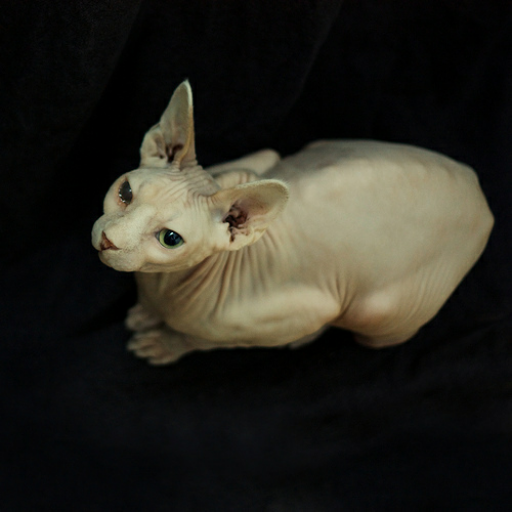

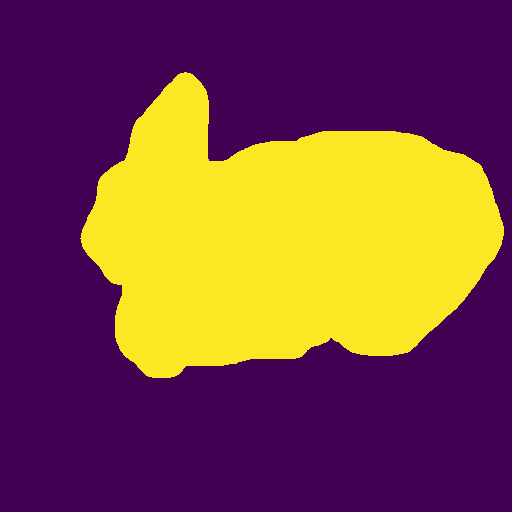

In [50]:
chunk_data_images = load_chunk_from_hdf5('/kaggle/working/OxfordPet/images_train.h5', 'dataset', 0, 5)

chunk_data_masks = load_chunk_from_hdf5('/kaggle/working/OxfordPet/masks_train.h5', 'dataset', 0, 5)

print(f'Images shape: {chunk_data_images.shape}, Masks shape: {chunk_data_masks.shape}')
plt.imsave('./image_example_train.png', chunk_data_images[0], format='png')
plt.imsave('./mask_example_train.png', chunk_data_masks[0,:,:,0], format='png')
display(Image(filename='/kaggle/working/image_example_train.png'))
display(Image(filename='/kaggle/working/mask_example_train.png'))

## Definition of performance metrics

### DICE metric

$$\text{Dice} = {2 \cdot |\text{Intersection}| + \text{smooth} \over |\text{Union}| + \text{smooth}}$$

Where:

$|\text{Intersection}| = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $|\text{Union}| = \sum_{i=1}^{N} y\_{true\_i} + \sum_{i=1}^{N} y\_{pred\_i}$


- $N$ is the total number of elements in the segmentation masks.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted segmentation masks, respectively.
- $\text{smooth}$ is a smoothing parameter to avoid division by zero.

In [36]:
class DiceMetric:
    """
    Class for calculating the Dice coefficient metric for image segmentation.

    This class provides a method for calculating the Dicecoefficient between 
    a ground truth image and a predicted image, measures their similarity,
    as well as a method for calculating the total Dice coefficient for a set of images.

    Attributes:
        None

    Methods:
        calculate: Calculates the Dice coefficient between a ground truth image
                   and a predicted image.
        total_dice: Calculates the total Dice coefficient for a set of images.
    """
    
    def __init__(self):
        """
        Initializes the dice_metric class.
        """
        pass
    
    def calculate(self,y_true, y_pred, axis=(1, 2), smooth=1e-5):
        """
        Calculates the Dice coefficient between a ground truth image and a
        predicted image.

        Parameters:
            y_true: Ground truth image.
            y_pred: Predicted image.
            axis: Axes over which to sum the intersection and union of the images.
            smooth: Small value added to the numerator and denominator to avoid
                    division by zero.

        Returns:
            None
        """
        global dice_total
        y_true = np.squeeze(y_true, axis=-1).astype(np.float32)
        y_pred = y_pred.astype(np.float32)
        intersection = np.sum(y_true * y_pred, axis=axis)
        union = np.sum(y_true, axis=axis) + np.sum(y_pred, axis=axis)
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_total.append(dice)
    
    def total_dice(self):
        """
        Calculates the total Dice coefficient for a set of images.

        Parameters:
            None

        Returns:
            value: The total Dice coefficient for the set of images.
        """
        value = np.concatenate(dice_total, axis=0)
        return np.mean(value)

### Jaccard metric

$$\text{Jaccard} = {|\text{Intersection}| + \text{smooth} \over |\text{Union}| + \text{smooth}}$$

Where:

$|\text{Intersection}| = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $|\text{Union}| = \sum_{i=1}^{N} y\_{true\_i} + \sum_{i=1}^{N} y\_{pred\_i} - |\text{Intersection}|$
- $N$ is the total number of elements in the segmentation masks.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted segmentation masks, respectively.
- $\text{smooth}$ is a small smoothing parameter to avoid division by zero.

In [37]:
class JaccardMetric:
    """
    Class for calculating the Jaccard similarity coefficient metric for image
    segmentation.

    The Jaccard similarity coefficient, also known as the Intersection over Union (IoU),
    measures the similarity between two sets by comparing their intersection to their union.
    In the context of semantic segmentation, it quantifies the overlap between the ground
    truth segmentation masks and the predicted segmentation masks.

    Attributes:
        None

    Methods:
        calculate: Calculates the Jaccard similarity coefficient between a ground
                   truth image and a predicted image.
        total_jaccard: Calculates the total Jaccard similarity coefficient for a
                       set of images.
    """
    def __init__(self):
        """
        Initializes the JaccardMetric class.
        """
        pass
    
    def calculate(self, y_true, y_pred, axis=(1, 2), smooth=1e-5):
        """
        Calculates the Jaccard similarity coefficient between a ground truth image
        and a predicted image.

        Parameters:
            y_true: Ground truth image.
            y_pred: Predicted image.
            axis: Axes over which to sum the intersection and union of the images.
            smooth: Small value added to the numerator and denominator to avoid
                    division by zero.

        Returns:
            None
        """
        global jaccard_total
        y_true = np.squeeze(y_true, axis=-1).astype(np.float32)
        y_pred = y_pred.astype(np.float32)
        intersection = np.sum(y_true * y_pred, axis=axis)
        union = np.sum(y_true, axis=axis) + np.sum(y_pred, axis=axis) - intersection
        jaccard = (intersection + smooth) / (union + smooth)
        jaccard_total.append(jaccard)
        
    def total_jaccard(self):
        """
        Calculates the total Jaccard similarity coefficient for a set of images.

        Parameters:
            None

        Returns:
            value: The total Jaccard similarity coefficient for the set of images.
        """
        value = np.concatenate(jaccard_total, axis=0)
        return np.mean(value)

### Sensitivity metric

$$\text{Sensitivity} = {\text{True Positives} \over \text{Actual Positives} + \text{smooth}}$$

Where:

$\text{True Positives} = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $\text{Actual Positives} = \sum_{i=1}^{N} y\_{true\_i}$


- $N$ is the total number of elements in the labels.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted labels, respectively.
- $\text{smooth}$ is a small value added to the denominator to avoid division by zero.

In [57]:
class SensitivityMetric:
    """
    Class for calculating the sensitivity metric for image segmentation.

    Sensitivity, also known as true positive rate or recall, measures the proportion
    of actual positives that are correctly identified by the model. It is computed
    as the ratio of true positives to the sum of true positives and false negatives.

    Attributes:
        None

    Methods:
        calculate: Calculates the sensitivity between a ground truth image and a
                   predicted image.
        total_sensitivity: Calculates the total sensitivity for a set of images.
    """
    def __init__(self):
        """
        Initializes the SensitivityMetric class.
        """
        pass
    
    def calculate(self, y_true, y_pred, axis=(1, 2), smooth=1e-5):
        """
        Calculates the sensitivity between a ground truth image and a predicted
        image.

        Parameters:
            y_true: Ground truth image.
            y_pred: Predicted image.
            axis: Axes over which to sum the true positives and actual positives.
            smooth: Small value added to the denominator to avoid division by zero.

        Returns:
            None
        """
        global sensitivity_total
        y_true = np.squeeze(y_true, axis=-1).astype(np.float32)
        y_pred = y_pred.astype(np.float32)
        true_positives = np.sum(y_true * y_pred, axis=axis)
        actual_positives = np.sum(y_true, axis=axis)
        sensitivity = true_positives / (actual_positives + smooth)
        sensitivity_total.append(sensitivity)
        
    def total_sensitivity(self):
        """
        Calculates the total sensitivity for a set of images.

        Parameters:
            None

        Returns:
            value: The total sensitivity for the set of images.
        """
        value = np.concatenate(sensitivity_total, axis=0)
        return np.mean(value)

### Specificity metric

$$\text{Specificity} = {\text{True Negatives} \over \text{Actual Negatives} + \text{smooth}}$$

Where:

$\text{True Negatives} = \sum_{i=1}^{N} (1 - y\_{true\_i}) \cdot (1 - y\_{pred\_i})$, $\text{Actual Negatives} = \sum_{i=1}^{N} (1 - y\_{true\_i})$

- $N$ is the total number of samples.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the ground truth label and predicted probability (or binary prediction) for the i-th sample, respectively.
- $\text{smooth}$ is a smoothing term to avoid division by zero.

In [58]:
class SpecificityMetric:
    """
    Class for calculating the specificity metric for image segmentation.

    Specificity measures the proportion of actual negative cases that were correctly
    identified as such. It is complementary to sensitivity (recall).

    Attributes:
        None

    Methods:
        calculate: Calculates the specificity between a ground truth image and a
                   predicted image.
        total_specificity: Calculates the total specificity for a set of images.
    """
    def __init__(self):
        """
        Initializes the SpecificityMetric class.
        """
        pass
    
    def calculate(self, y_true, y_pred, axis=(1, 2), smooth=1e-5):
        """
        Calculates the specificity between a ground truth image and a predicted
        image.

        Parameters:
            y_true: Ground truth image.
            y_pred: Predicted image.
            axis: Axes over which to sum the true negatives and actual negatives.
            smooth: Small value added to the denominator to avoid division by zero.

        Returns:
            None
        """
        global specificity_total
        y_true = np.squeeze(y_true, axis=-1).astype(np.float32)
        y_pred = y_pred.astype(np.float32)
        true_negatives = np.sum((1 - y_true) * (1 - y_pred), axis=axis)
        actual_negatives = np.sum(1 - y_true, axis=axis)
        specificity = true_negatives / (actual_negatives + smooth)
        specificity_total.append(specificity)
        
    def total_specificity(self):
        """
        Calculates the total specificity for a set of images.

        Parameters:
            None

        Returns:
            value: The total specificity for the set of images.
        """
        value = np.concatenate(specificity_total, axis=0)
        return np.mean(value)

### Model performance for the training part of the dataset

In [71]:
dice_total = []
jaccard_total = []
sensitivity_total = []
specificity_total = []

train_dice = DiceMetric()
train_jaccard = JaccardMetric()
train_sensitivity = SensitivityMetric()
train_specificity = SpecificityMetric()

for batch in range(0, 11, 5):
    
    original_images = load_chunk_from_hdf5('/kaggle/working/OxfordPet/images_train.h5', 'dataset', batch, batch+5)
    original_masks = load_chunk_from_hdf5('/kaggle/working/OxfordPet/masks_train.h5', 'dataset', batch, batch+5)
    original_masks = original_masks > 0.5
    input_tensor = ((torch.from_numpy(original_images)).permute(0, 3, 1, 2)).to(device)
    A_id_tensor = torch.zeros(5, 3).to(device)
    with torch.no_grad():
        output, cm = model(input_tensor, A_id_tensor)
    output = output.detach().cpu()
    cm = cm.detach().cpu()
    predicted_masks = output[:,1,:,:].numpy()
    
    train_dice.calculate(original_masks, predicted_masks)
    train_jaccard.calculate(original_masks, predicted_masks)
    train_sensitivity.calculate(original_masks, predicted_masks)
    train_specificity.calculate(original_masks, predicted_masks)
    
    del input_tensor, A_id_tensor, output, cm
    torch.cuda.empty_cache()
    
print(f'Dice: {train_dice.total_dice()}, Jaccard: {train_jaccard.total_jaccard()}, Sensitivity: {train_sensitivity.total_sensitivity()}, Specificity: {train_specificity.total_specificity()}')

Dice: 0.31218644976615906, Jaccard: 0.29383283853530884, Sensitivity: 0.29909414052963257, Specificity: 0.9965699911117554


In [93]:
original_images = load_chunk_from_hdf5('/kaggle/working/OxfordPet/images_train.h5', 'dataset', 0, 13)
original_masks = load_chunk_from_hdf5('/kaggle/working/OxfordPet/masks_train.h5', 'dataset', 0, 13)

In [99]:
# Nombre del archivo HDF5 y nombre del dataset dentro del archivo
filename = '/kaggle/working/OxfordPet/images_train.h5'
dataset_name = 'dataset'

# Índices de inicio y fin para la porción de datos que deseas cargar
start_index = 0
end_index = 10  # Por ejemplo, cargar los primeros 10 ejemplos

# Función para cargar una porción del dataset desde un archivo HDF5
def load_data_from_hdf5(filename, dataset_name, start_index, end_index):
    with h5py.File(filename, 'r') as f:
        dataset = f[dataset_name]
        data_chunk = dataset[start_index:end_index]
        return data_chunk

# Ejemplo de uso:
data_loaded = load_data_from_hdf5(filename, dataset_name, start_index, end_index)

# Imprimir información sobre los datos cargados
print(f'Data loaded from {filename} for indices {start_index} to {end_index}:')
print(data_loaded.shape)  # Imprimir la forma de los datos cargados
print(data_loaded.dtype)  # Imprimir el tipo de datos cargados (por ejemplo, 'float32')

Data loaded from /kaggle/working/OxfordPet/images_train.h5 for indices 0 to 10:
(10, 512, 512, 3)
float32


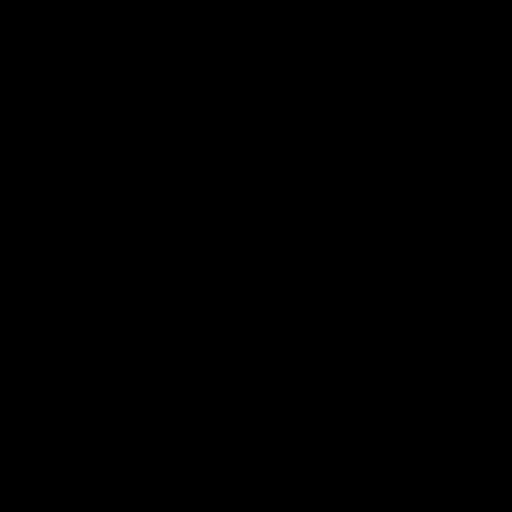

In [101]:
plt.imsave('./image_example_train_1.png', data_loaded[9], format='png')
display(Image(filename='/kaggle/working/image_example_train_1.png'))

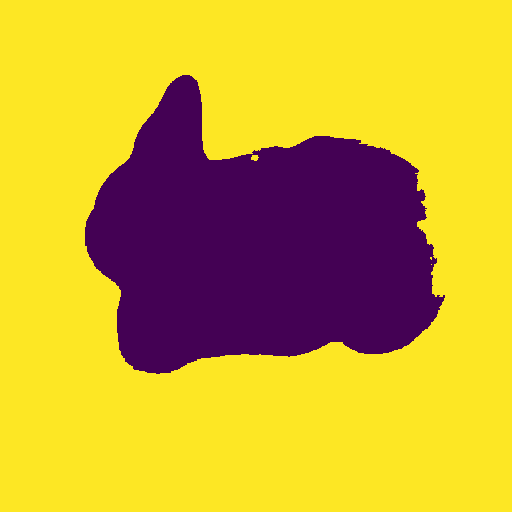

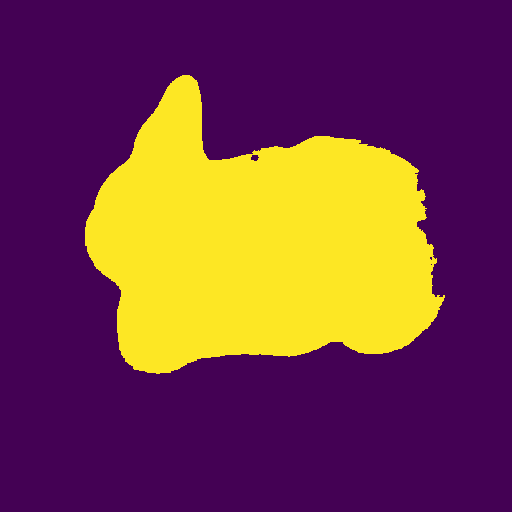

In [31]:
display(Image(filename='/kaggle/working/mask_example_model_prediction.png'))
display(Image(filename='/kaggle/working/mask_example_train_prediciton.png'))